In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import os
import sys
import re
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

sys.path.append(
    os.path.abspath(
        os.path.expanduser(
            '~/CNN-MARL_closure_model_discovery')))


from xlb_flows.utils import vorticity_2d, energy_spectrum_2d

In [3]:
#plotting utils 
# Custom sorting key
def custom_sort_key(folder):
    match = re.search(r'N(\d+)_', folder)
    if match:
        N = int(match.group(1))
        return (0 if N < 2048 else 1, N)
    return (1, 0)

# Custom sorting key names
def custom_sort_key_names(folder):
    match = re.search(r'(\d+)_', folder)
    if match:
        N = int(match.group(1))
        return (0 if N < 2048 else 1, N)
    return (1, 0)

# get all filenames in directory
def get_names(path):
    files = os.listdir(path)
    return np.sort(files)


def plot_correlations(corrs, names, N, M):
    t = np.linspace(0, 227, M)
    idex = np.argmin(np.abs(t - 26))
    their_t = t/16
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    for i in range(N-1):
        plt.plot(t, corrs[:,i], label=names[i])
    plt.plot(t, corrs[:,N-1], 'k--', label=names[N-1])
    plt.xlabel(r'non-dimensional time $T = (U/L)t$')
    plt.ylabel(r'vorticity correlation with DNS')
    plt.legend(loc='best')
    plt.show()


def plot_spectra(spec_mean, spec_std, k, names, N):
    # plot the averaged spectrum
    plt.figure(figsize=(10,6), dpi=300)
    plt.set_cmap('cool')
    for i in range(N-1):
        plt.loglog(spec_mean[i,...]*k**5, label=names[i])
        plt.fill_between(k,
                         spec_mean[i,...]*k**5 - spec_std[i,...]*k**5,
                         spec_mean[i,...]*k**5 + spec_std[i,...]*k**5,
                         alpha=0.3
                         )
    plt.loglog(spec_mean[-1,...]*k**5,
               'k--',
               label=names[-1]
               )
    plt.fill_between(k,
                     (k**5)*(spec_mean[-1,...]-spec_std[-1,...]),
                     (k**5)*(spec_mean[-1,...] + spec_std[-1,...]), 
                     alpha=0.3,
                     color='k'
                     )
    plt.ylabel(r'Energy spectrum $E(k)k^5$')
    plt.xlabel(r'wavenumber $k$')
    plt.legend()
    plt.show()  

    # plot the averaged spectrum
    plt.figure(figsize=(10,6), dpi=300)
    plt.set_cmap('cool')
    for i in range(N-1):
        plt.loglog(spec_mean[i,...], label=names[i])
        plt.fill_between(k,
                         spec_mean[i,...]-spec_std[i,...],
                         spec_mean[i,...] + spec_std[i,...],
                         alpha=0.3
                         )
    plt.loglog(spec_mean[-1,...],
               'k--',
               label=names[-1]
               )
    plt.fill_between(k,
                     spec_mean[-1,...]-spec_std[-1,...],
                     spec_mean[-1,...] + spec_std[-1,...],
                     alpha=0.3,
                     color='k'
                     )
    #plt.loglog(1e2*k**(-5.), label="k^-5/3", linestyle="--")
    plt.ylabel(r'Energy spectrum $E(k)$')
    plt.xlabel(r'wavenumber $k$')
    plt.legend()
    plt.show()


def create_plots(test_directory):
    # Get all folder names within `test_directory`
    subfolders = [name for name in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, name))]
    subfolders = np.sort(subfolders)

    # Sort folders with custom key
    subfolders = sorted(subfolders, key=custom_sort_key)
    
    # Extract names={N}_{model} from each folder name
    names = []
    for folder in subfolders:
        match = re.search(r'N(\d+)_S\d+_U\d+_(\w+)', folder)
        if match:
            N = match.group(1)
            model = match.group(2)
            names.append(f"{N}_{model}")

    names = sorted(names, key=custom_sort_key_names)
    paths = [test_directory+subfolder+"/" for subfolder in subfolders]

    #load all velocity files for all paths, and compute vorticity correlation
    images = [get_names(path) for path in paths]
    N = len(paths)
    M = len(images[0])-1
    corrs = np.zeros((M,N))
    print("computing vorticity correlations:")
    for i in tqdm(range(M)):
        #load all velocities 
        velocities = np.array([np.load(paths[j]+'/'+images[j][i]) for j in range(N)])
        vorticities = np.array([vorticity_2d(velocities[j,...], 2.0*np.pi/128) for j in range(N)])
        corrs[i,...] = np.array([np.corrcoef(vorticities[j,...].flatten(), vorticities[-1,...].flatten())[0, 1] 
                                 for j in range(N)])
    #plot correlations
    plot_correlations(corrs, names, N, M)

    #compute enerty spectrum statistics
    L = int(128/2 - 1)
    a = 1*M//2 #1*M//2
    b = M-1
    spec = np.zeros((N, L, (b-a)))
    k = np.arange(L)
    # loop over all files in files1 between a and b and add to spec
    print("computing energy spectra:")
    for i in tqdm(range(a, b)):
        velocities = np.array([np.load(paths[j]+'/'+images[j][i]) for j in range(N)])
        for j in range(N):
            _, spec[j,:,i-a] = energy_spectrum_2d(velocities[j,...])
    spec_mean=spec.mean(axis=-1)
    spec_std=spec.std(axis=-1)

    # plot spectra
    plot_spectra(spec_mean, spec_std, k, names, N)


    # plot vorticity fields
    f_size = 10

    # Sample time steps for demonstration
    ts = np.array([0, 1/3, 2/3, 1]) * (M-2)
    time_labels = np.array([0, 1/3, 2/3, 1]) * (227)

    # Plot vorticity images at times t1 to t5 for all resolutions
    fig, axs = plt.subplots(N, 4, figsize=(4.2, N+1), dpi=300)

    for i in range(4):
        for j in range(N):
            u = np.load(paths[j] + '/' + images[j][int(ts[i])]) 
            v = vorticity_2d(u, 2.0 * np.pi / 128)       
            axs[j, i].imshow(v, vmin=-10, vmax=10, cmap=sns.cm.icefire)
            axs[j, i].set_xticks([])  # Disable x-ticks
            axs[j, i].set_yticks([])  # Disable y-ticks

    # Add row labels
    for i, ax in enumerate(axs[:, 0]):
        ax.set_ylabel(f"{names[i]}", fontsize=f_size)

    # Add time labels to each column
    for i, ax in enumerate(axs[0, :]):
        ax.set_title(f"t={time_labels[i]:.1f}", fontsize=f_size)

    # Set up the colorbar with continuous color gradient, arrowed edges, and specified ticks
    vmin, vmax = -10, 10
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust to span entire height
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=sns.cm.icefire, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, extend='both', extendfrac=0.07, aspect=10)  # Extend arrows and adjust aspect ratio
    cbar.set_label('Vorticity', fontsize=f_size)
    cbar.ax.tick_params(labelsize=f_size)

    # Set 5 evenly spaced ticks on the colorbar
    cbar.set_ticks(np.linspace(vmin, vmax, 5))

    # Adjust spacing between subplots
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.06, hspace=0.015)

    plt.show()


computing vorticity correlations:


100%|██████████| 626/626 [00:01<00:00, 327.26it/s]


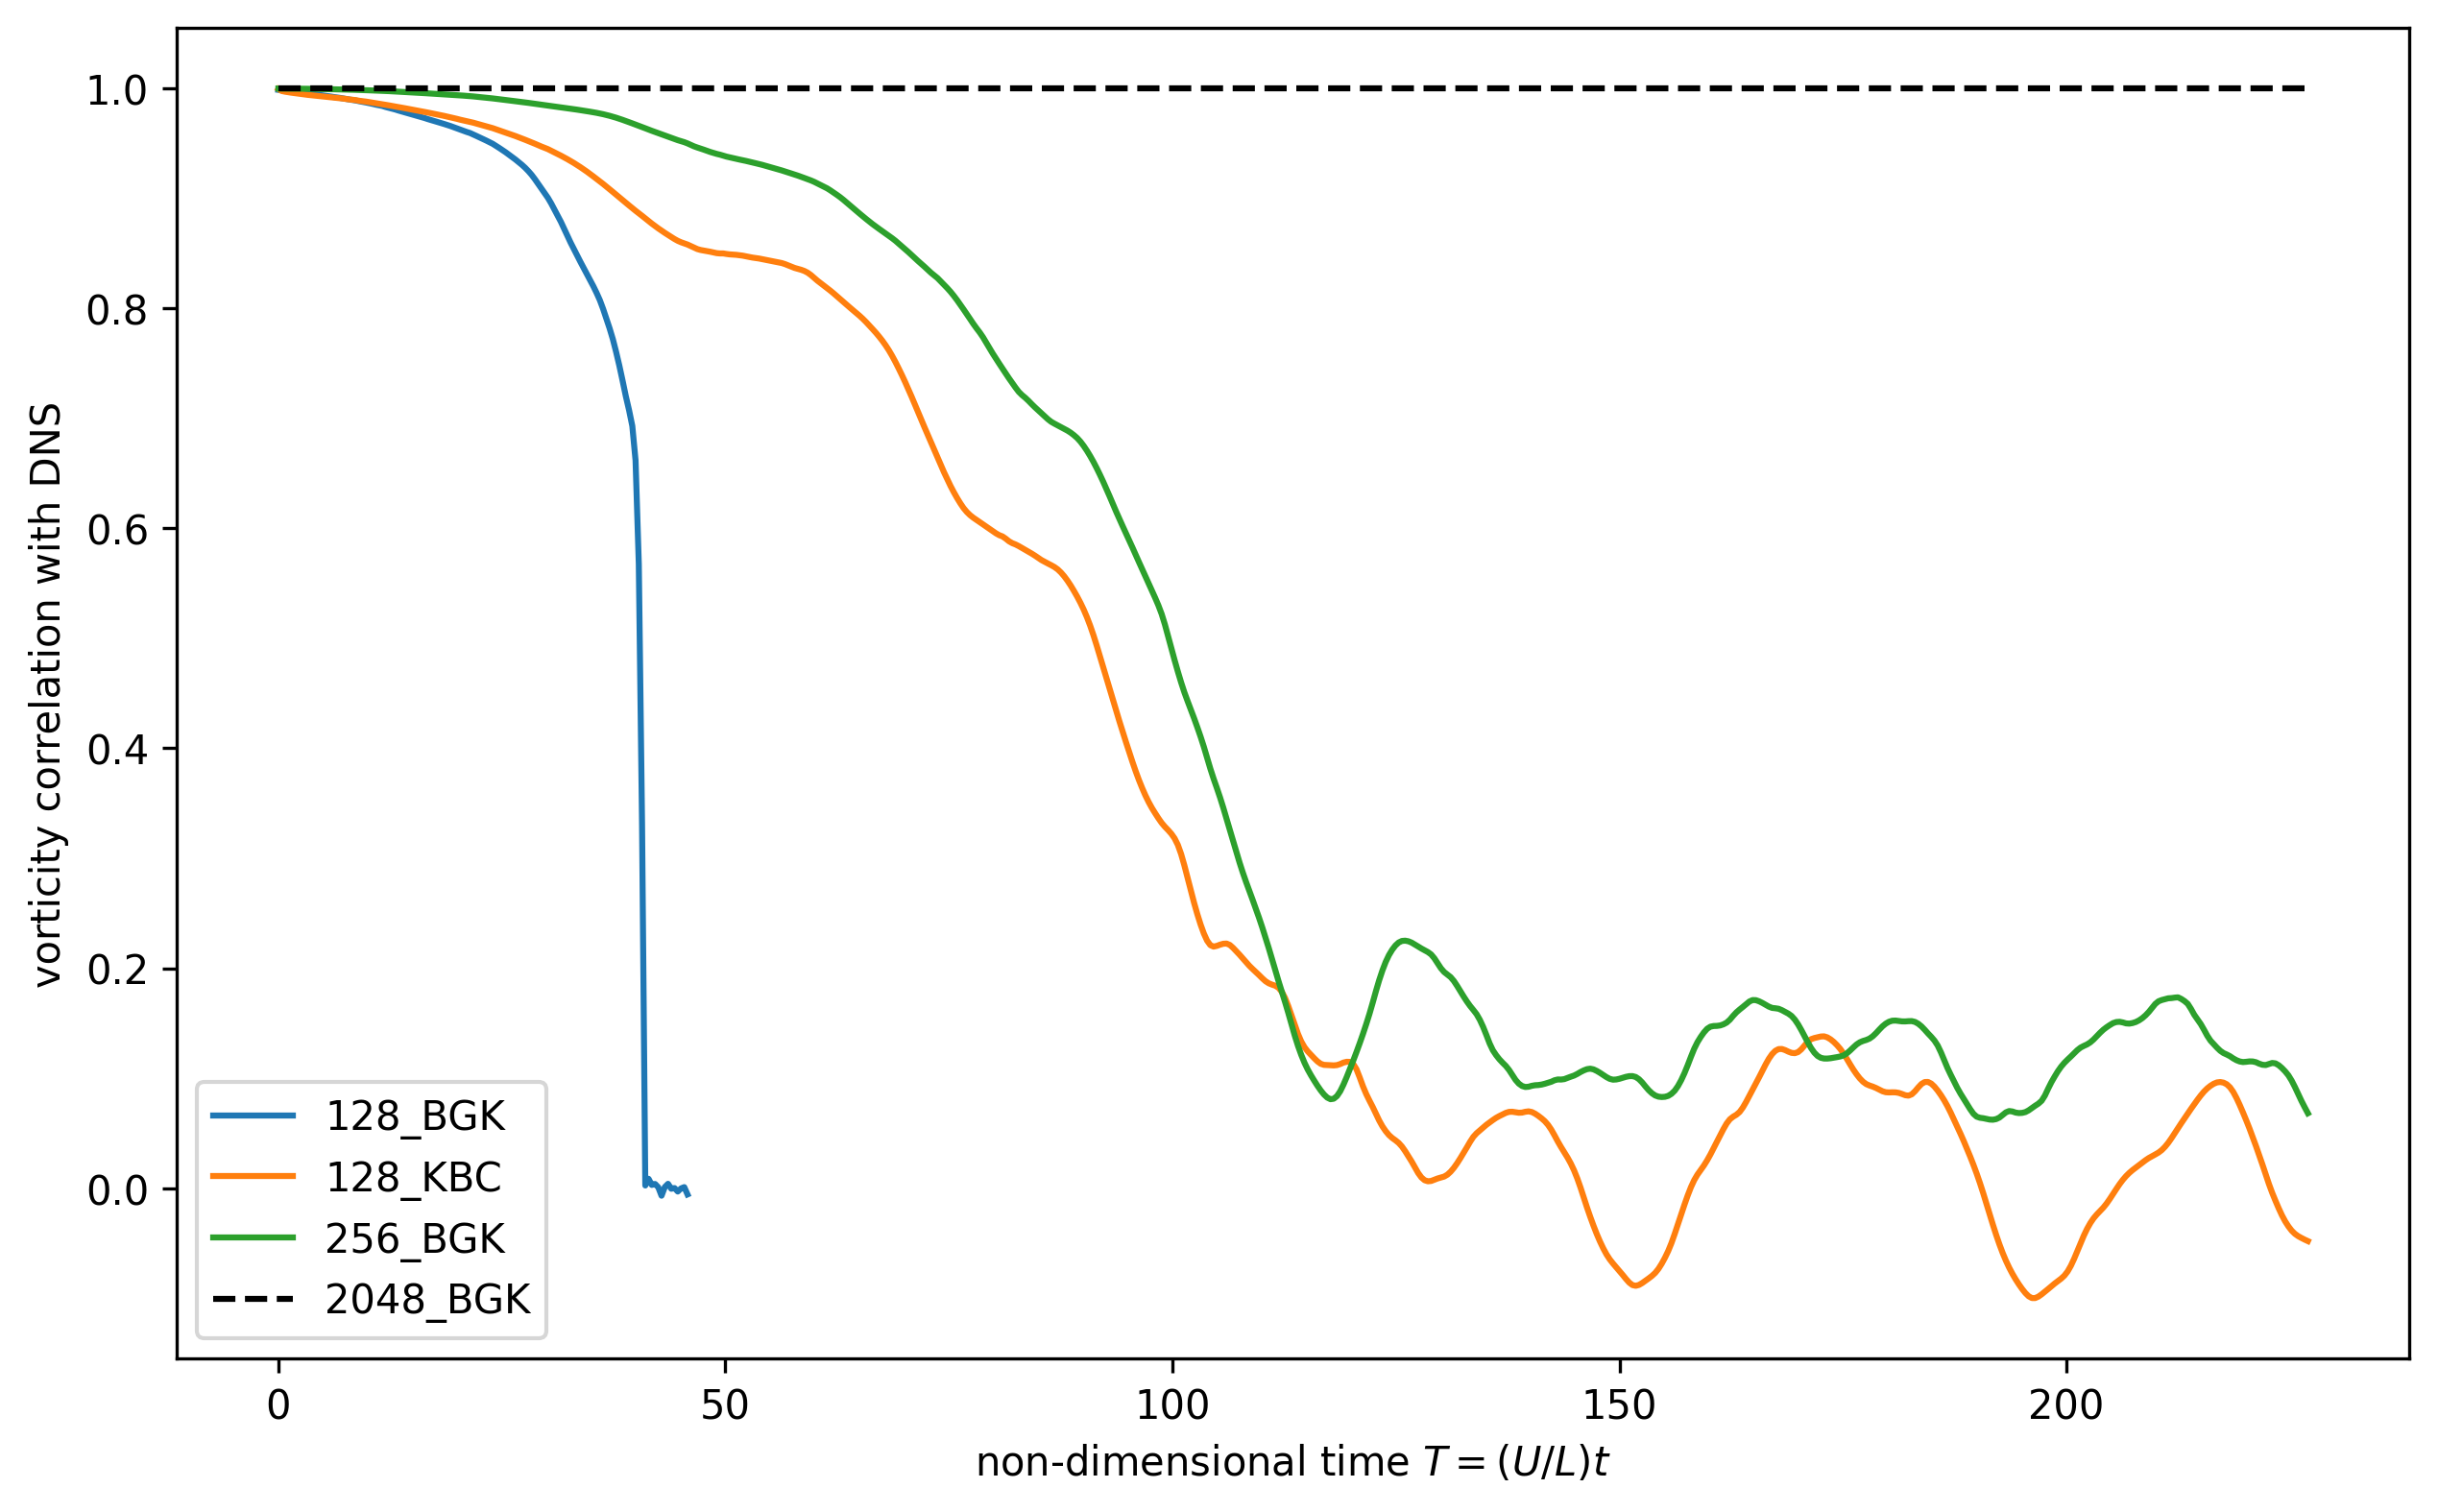

computing energy spectra:


100%|██████████| 312/312 [00:03<00:00, 101.17it/s]


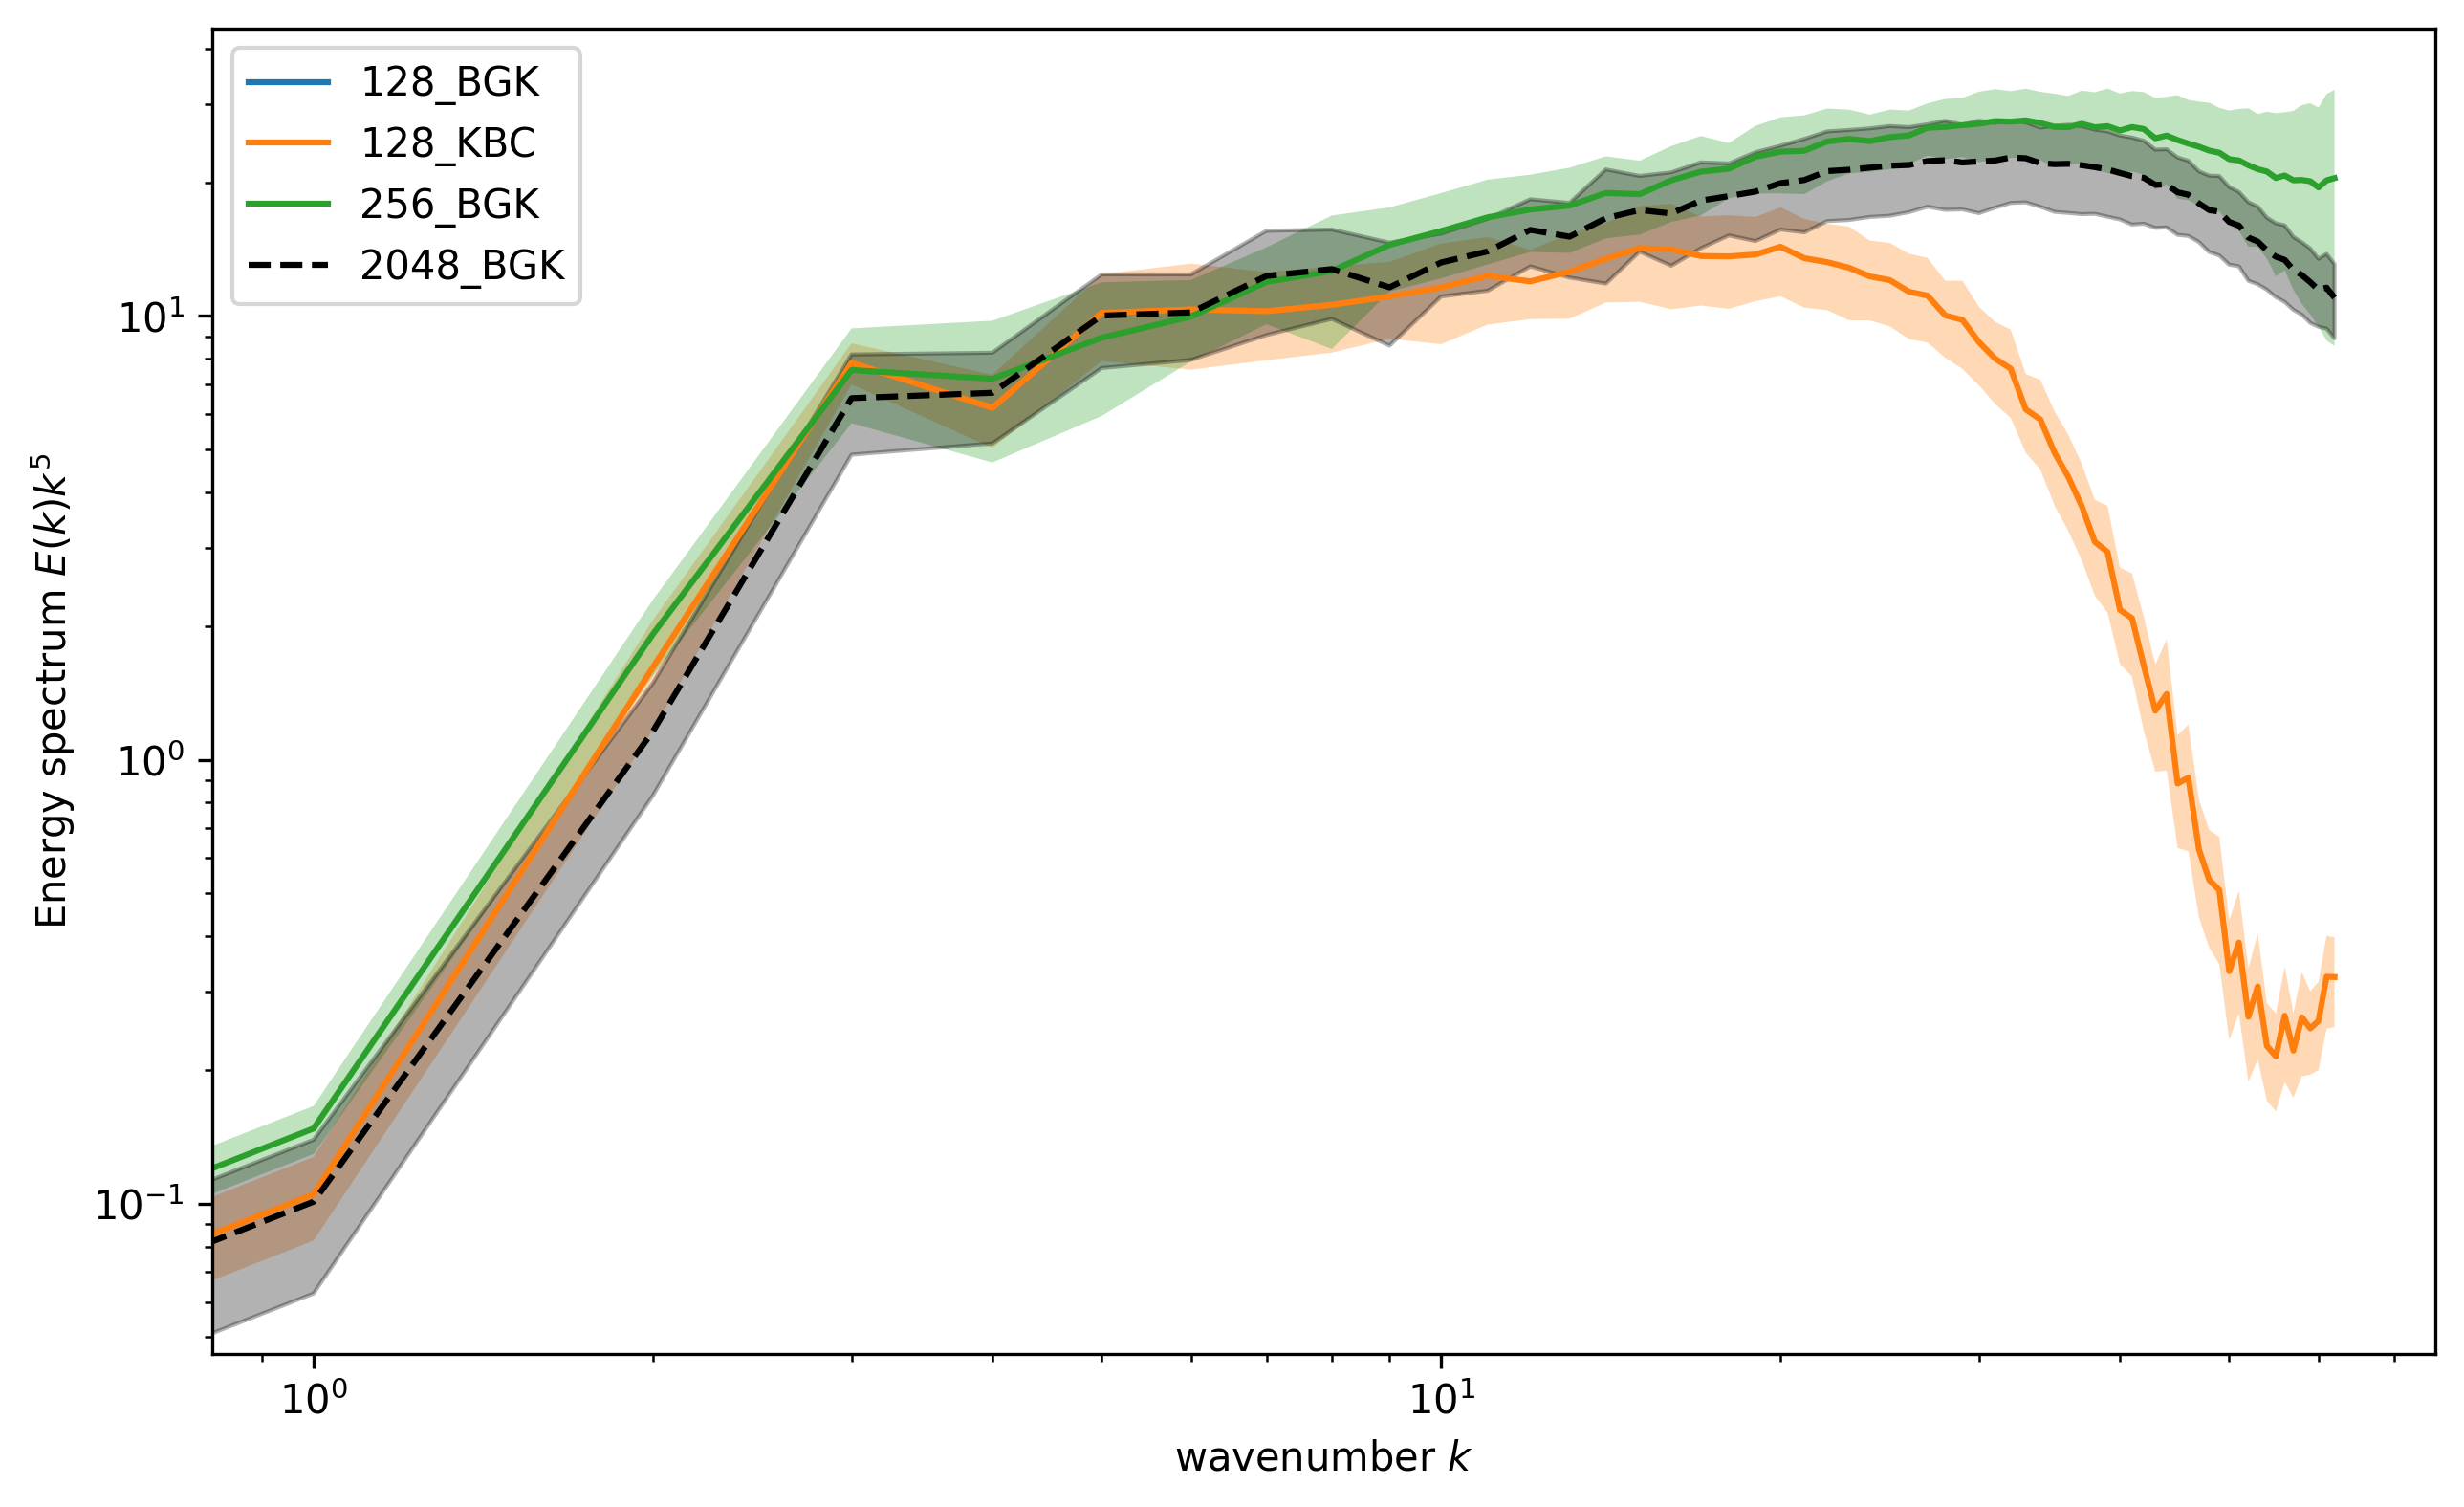

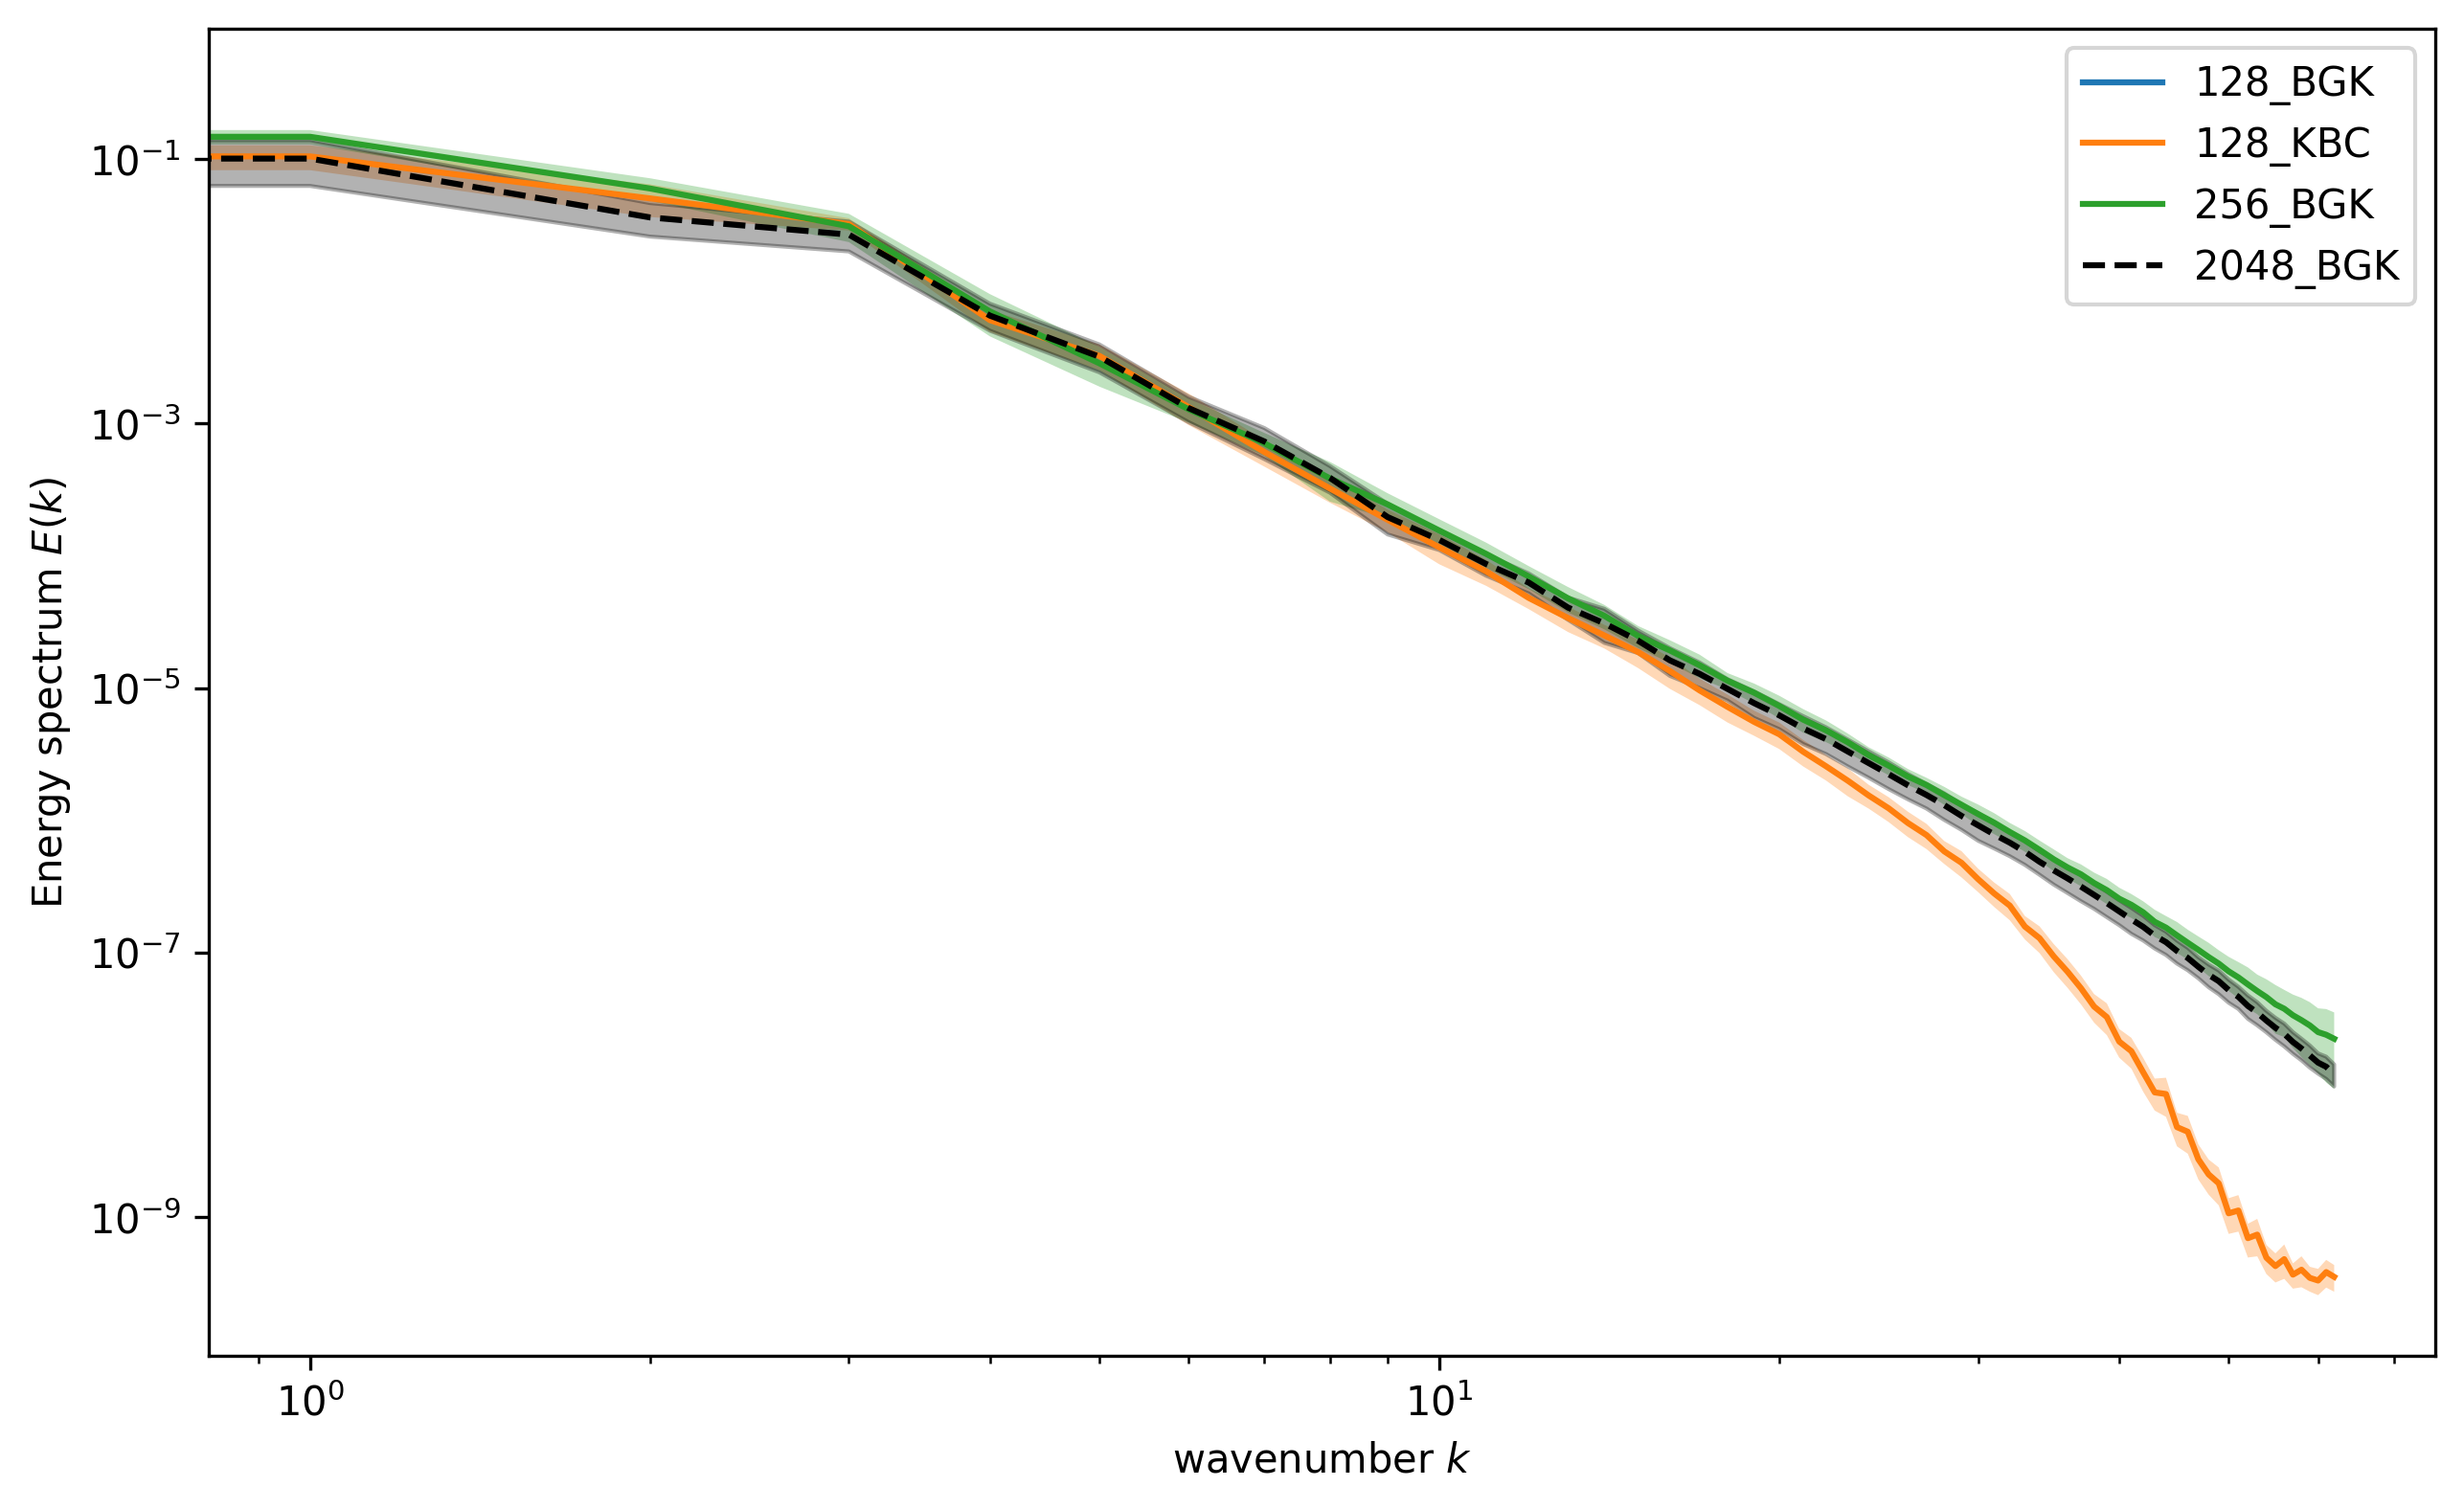

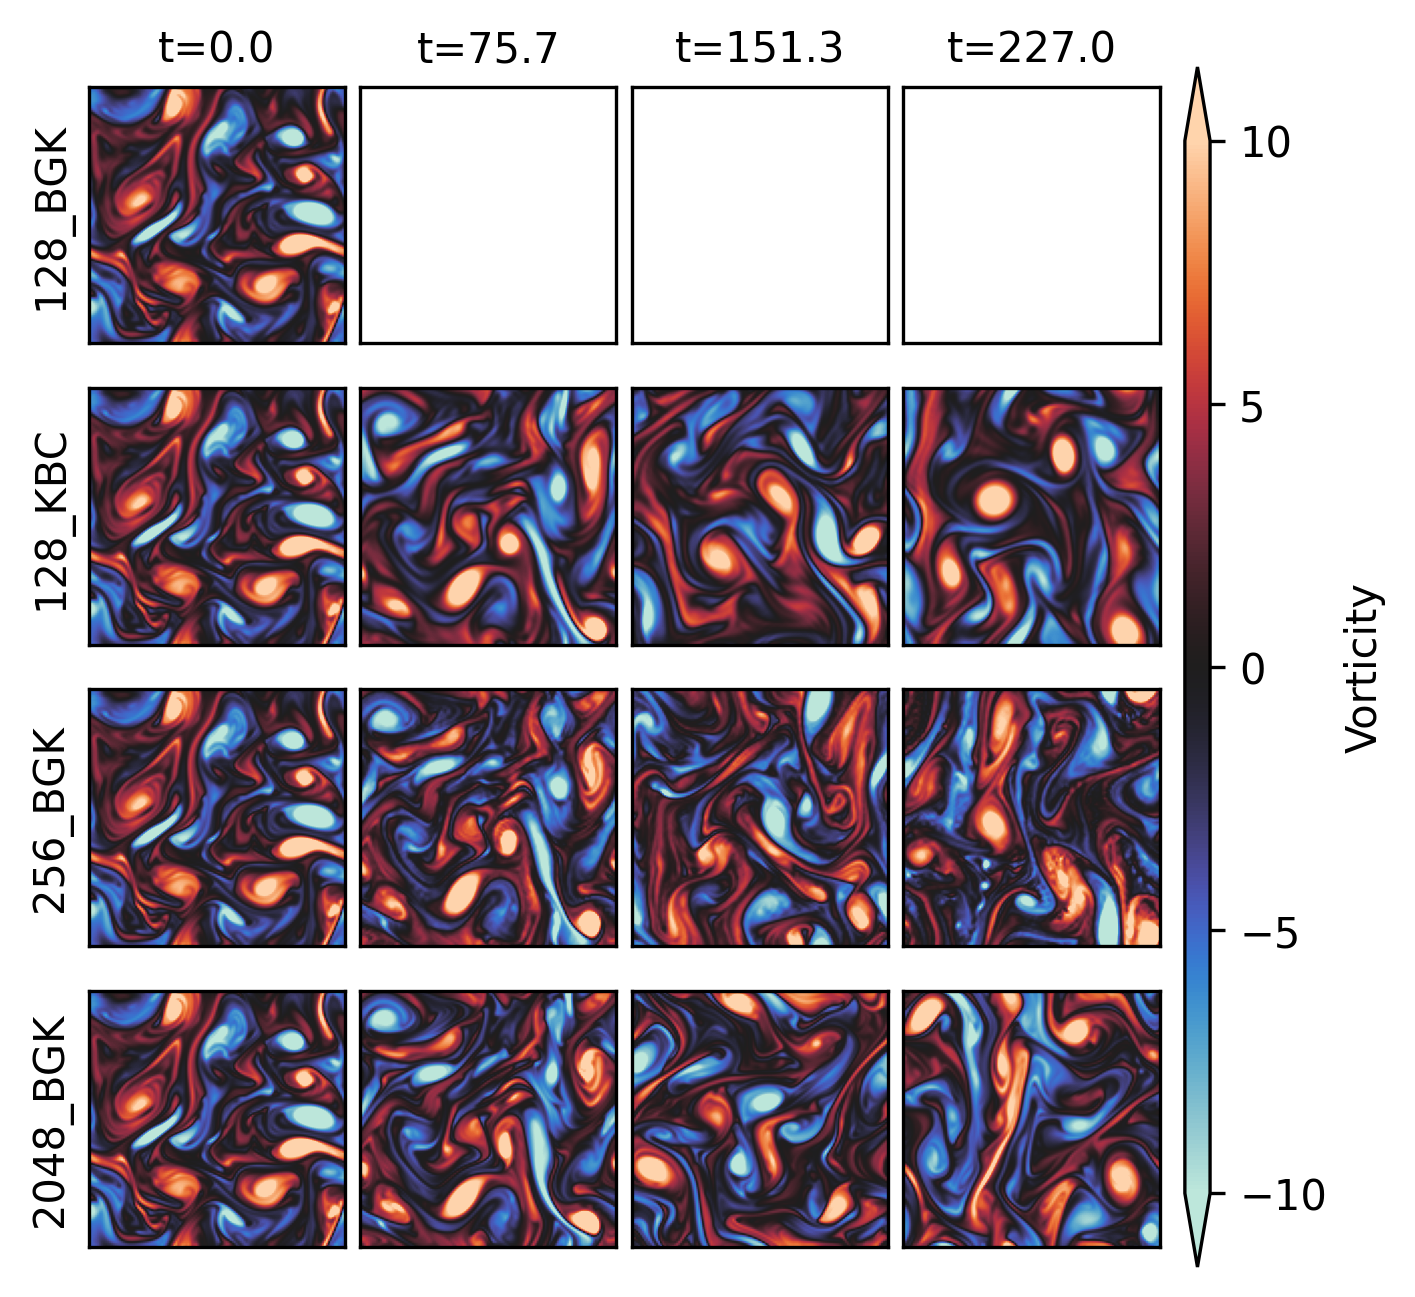

In [4]:
create_plots('re10000_T227_S33_Kolmogorov_runs/')

computing vorticity correlations:


100%|██████████| 626/626 [00:01<00:00, 528.30it/s]


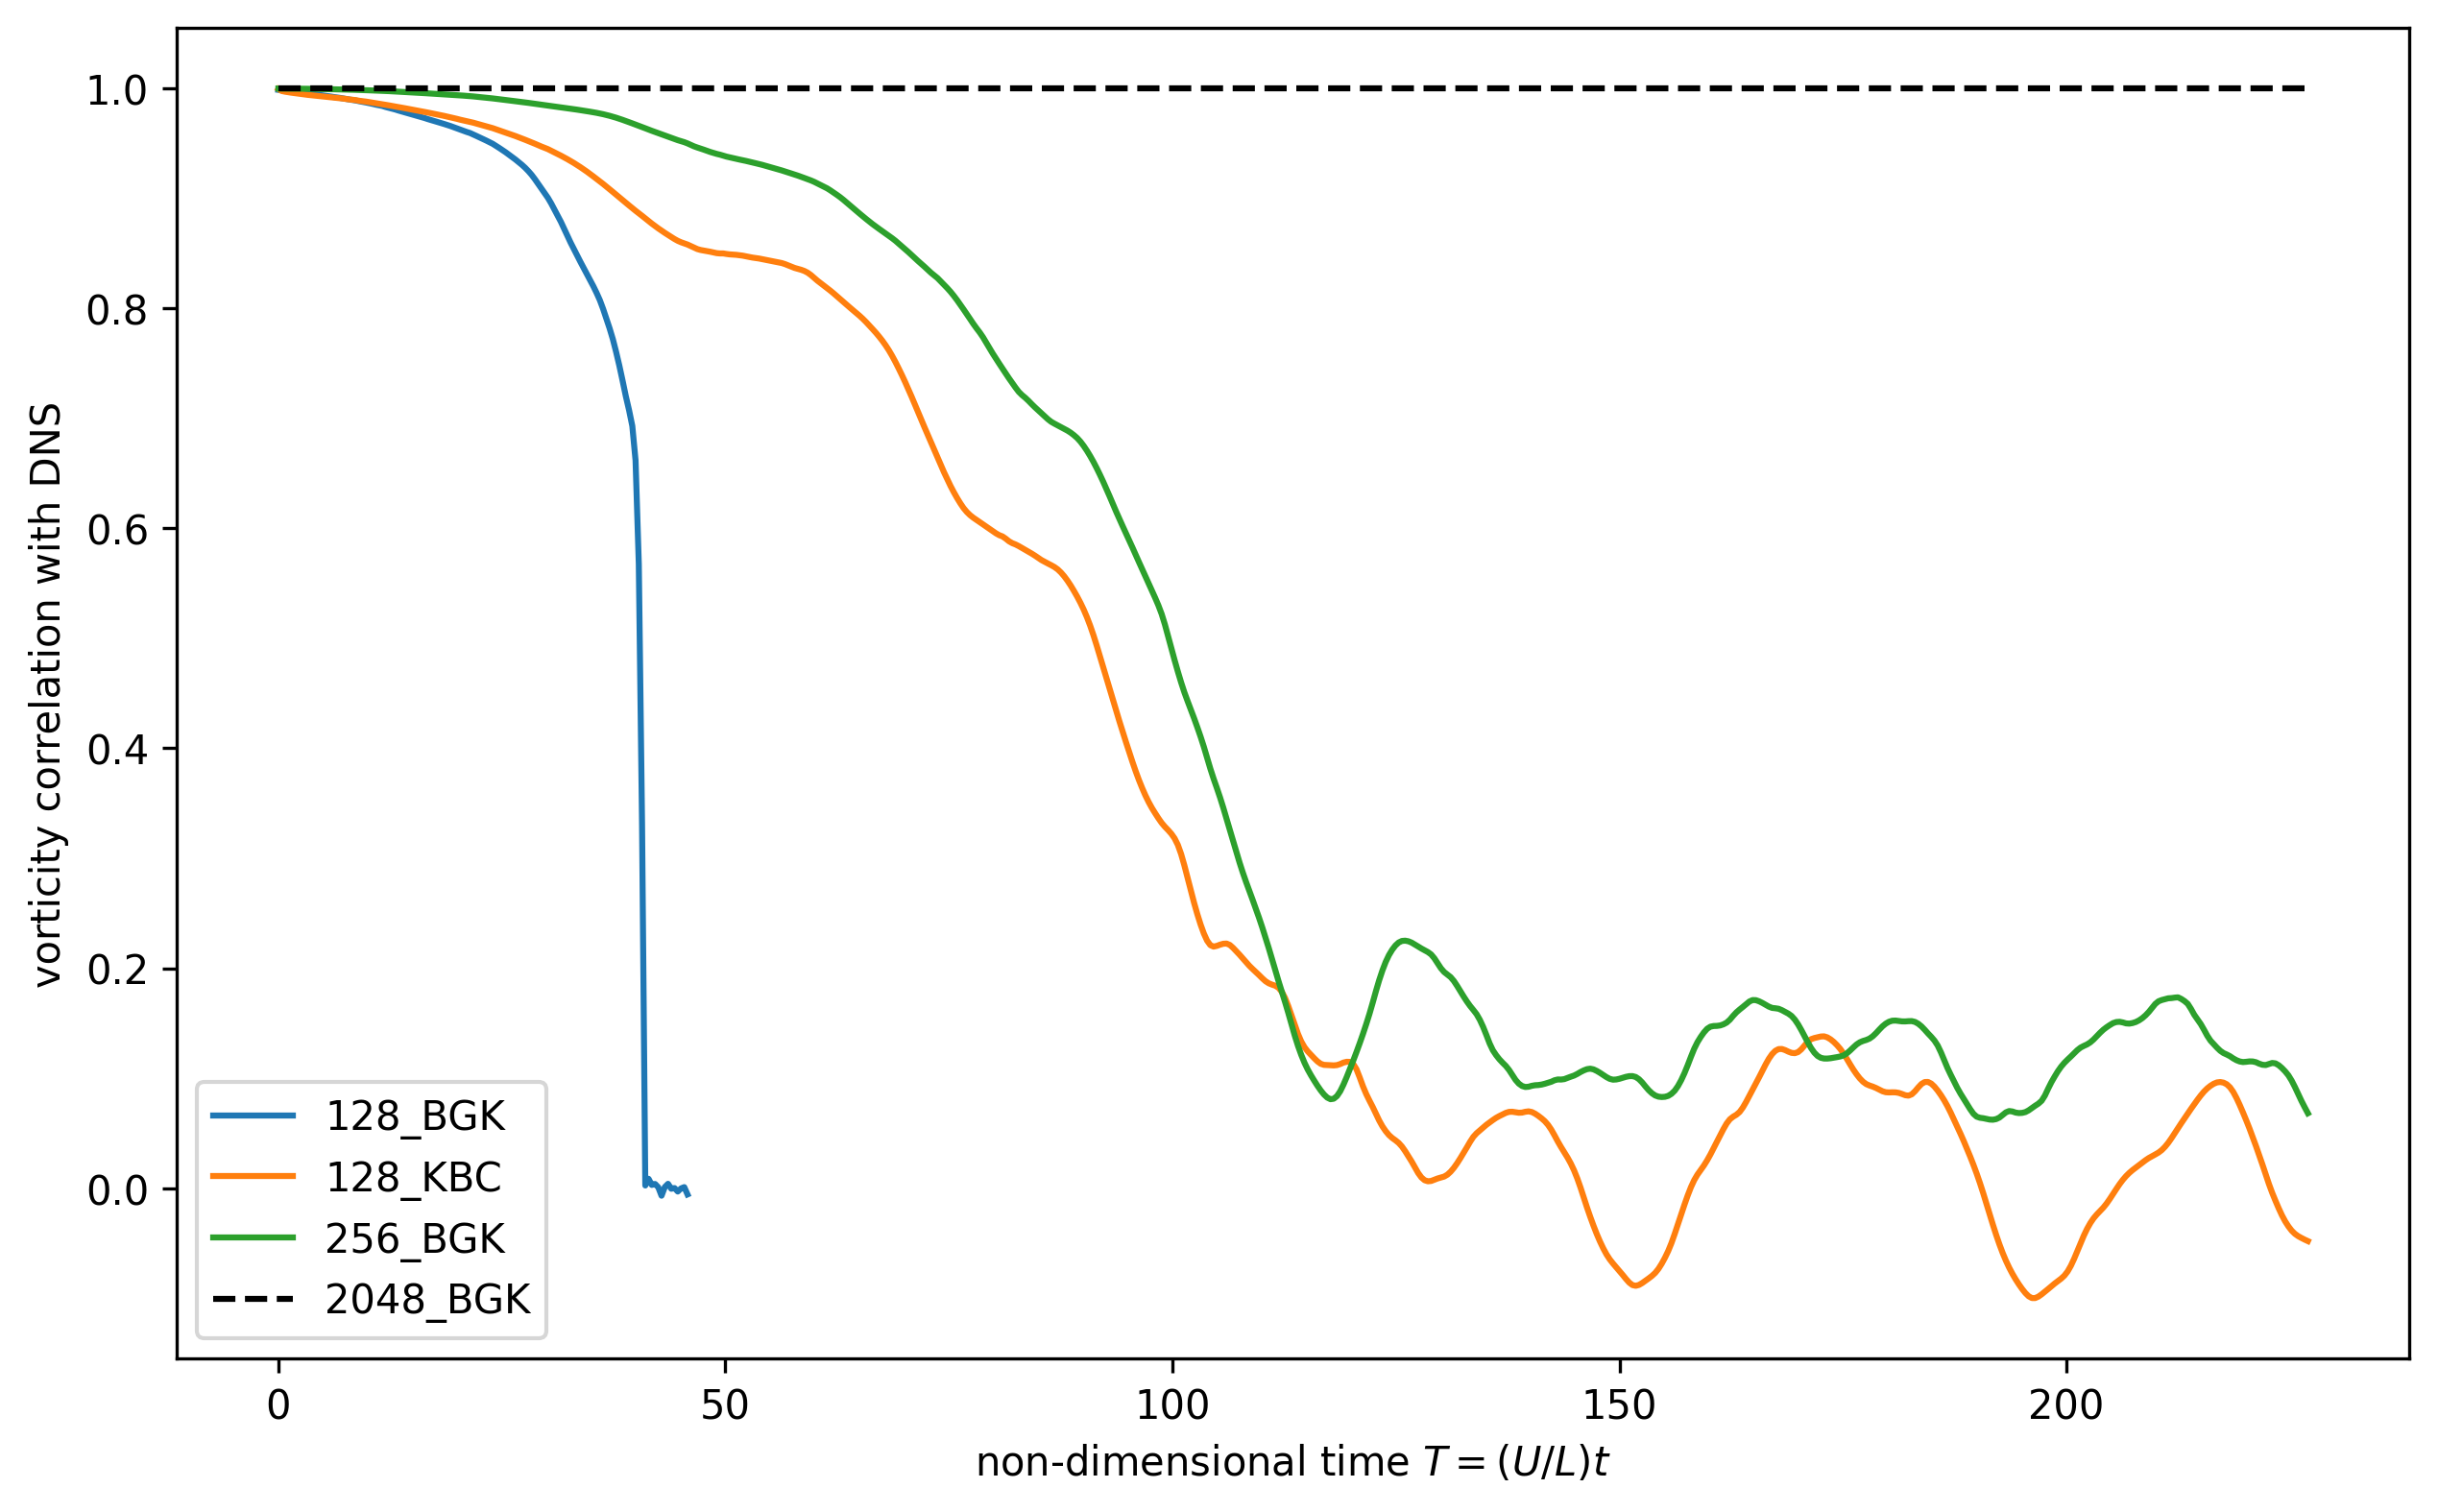

computing energy spectra:


100%|██████████| 312/312 [00:03<00:00, 99.48it/s] 


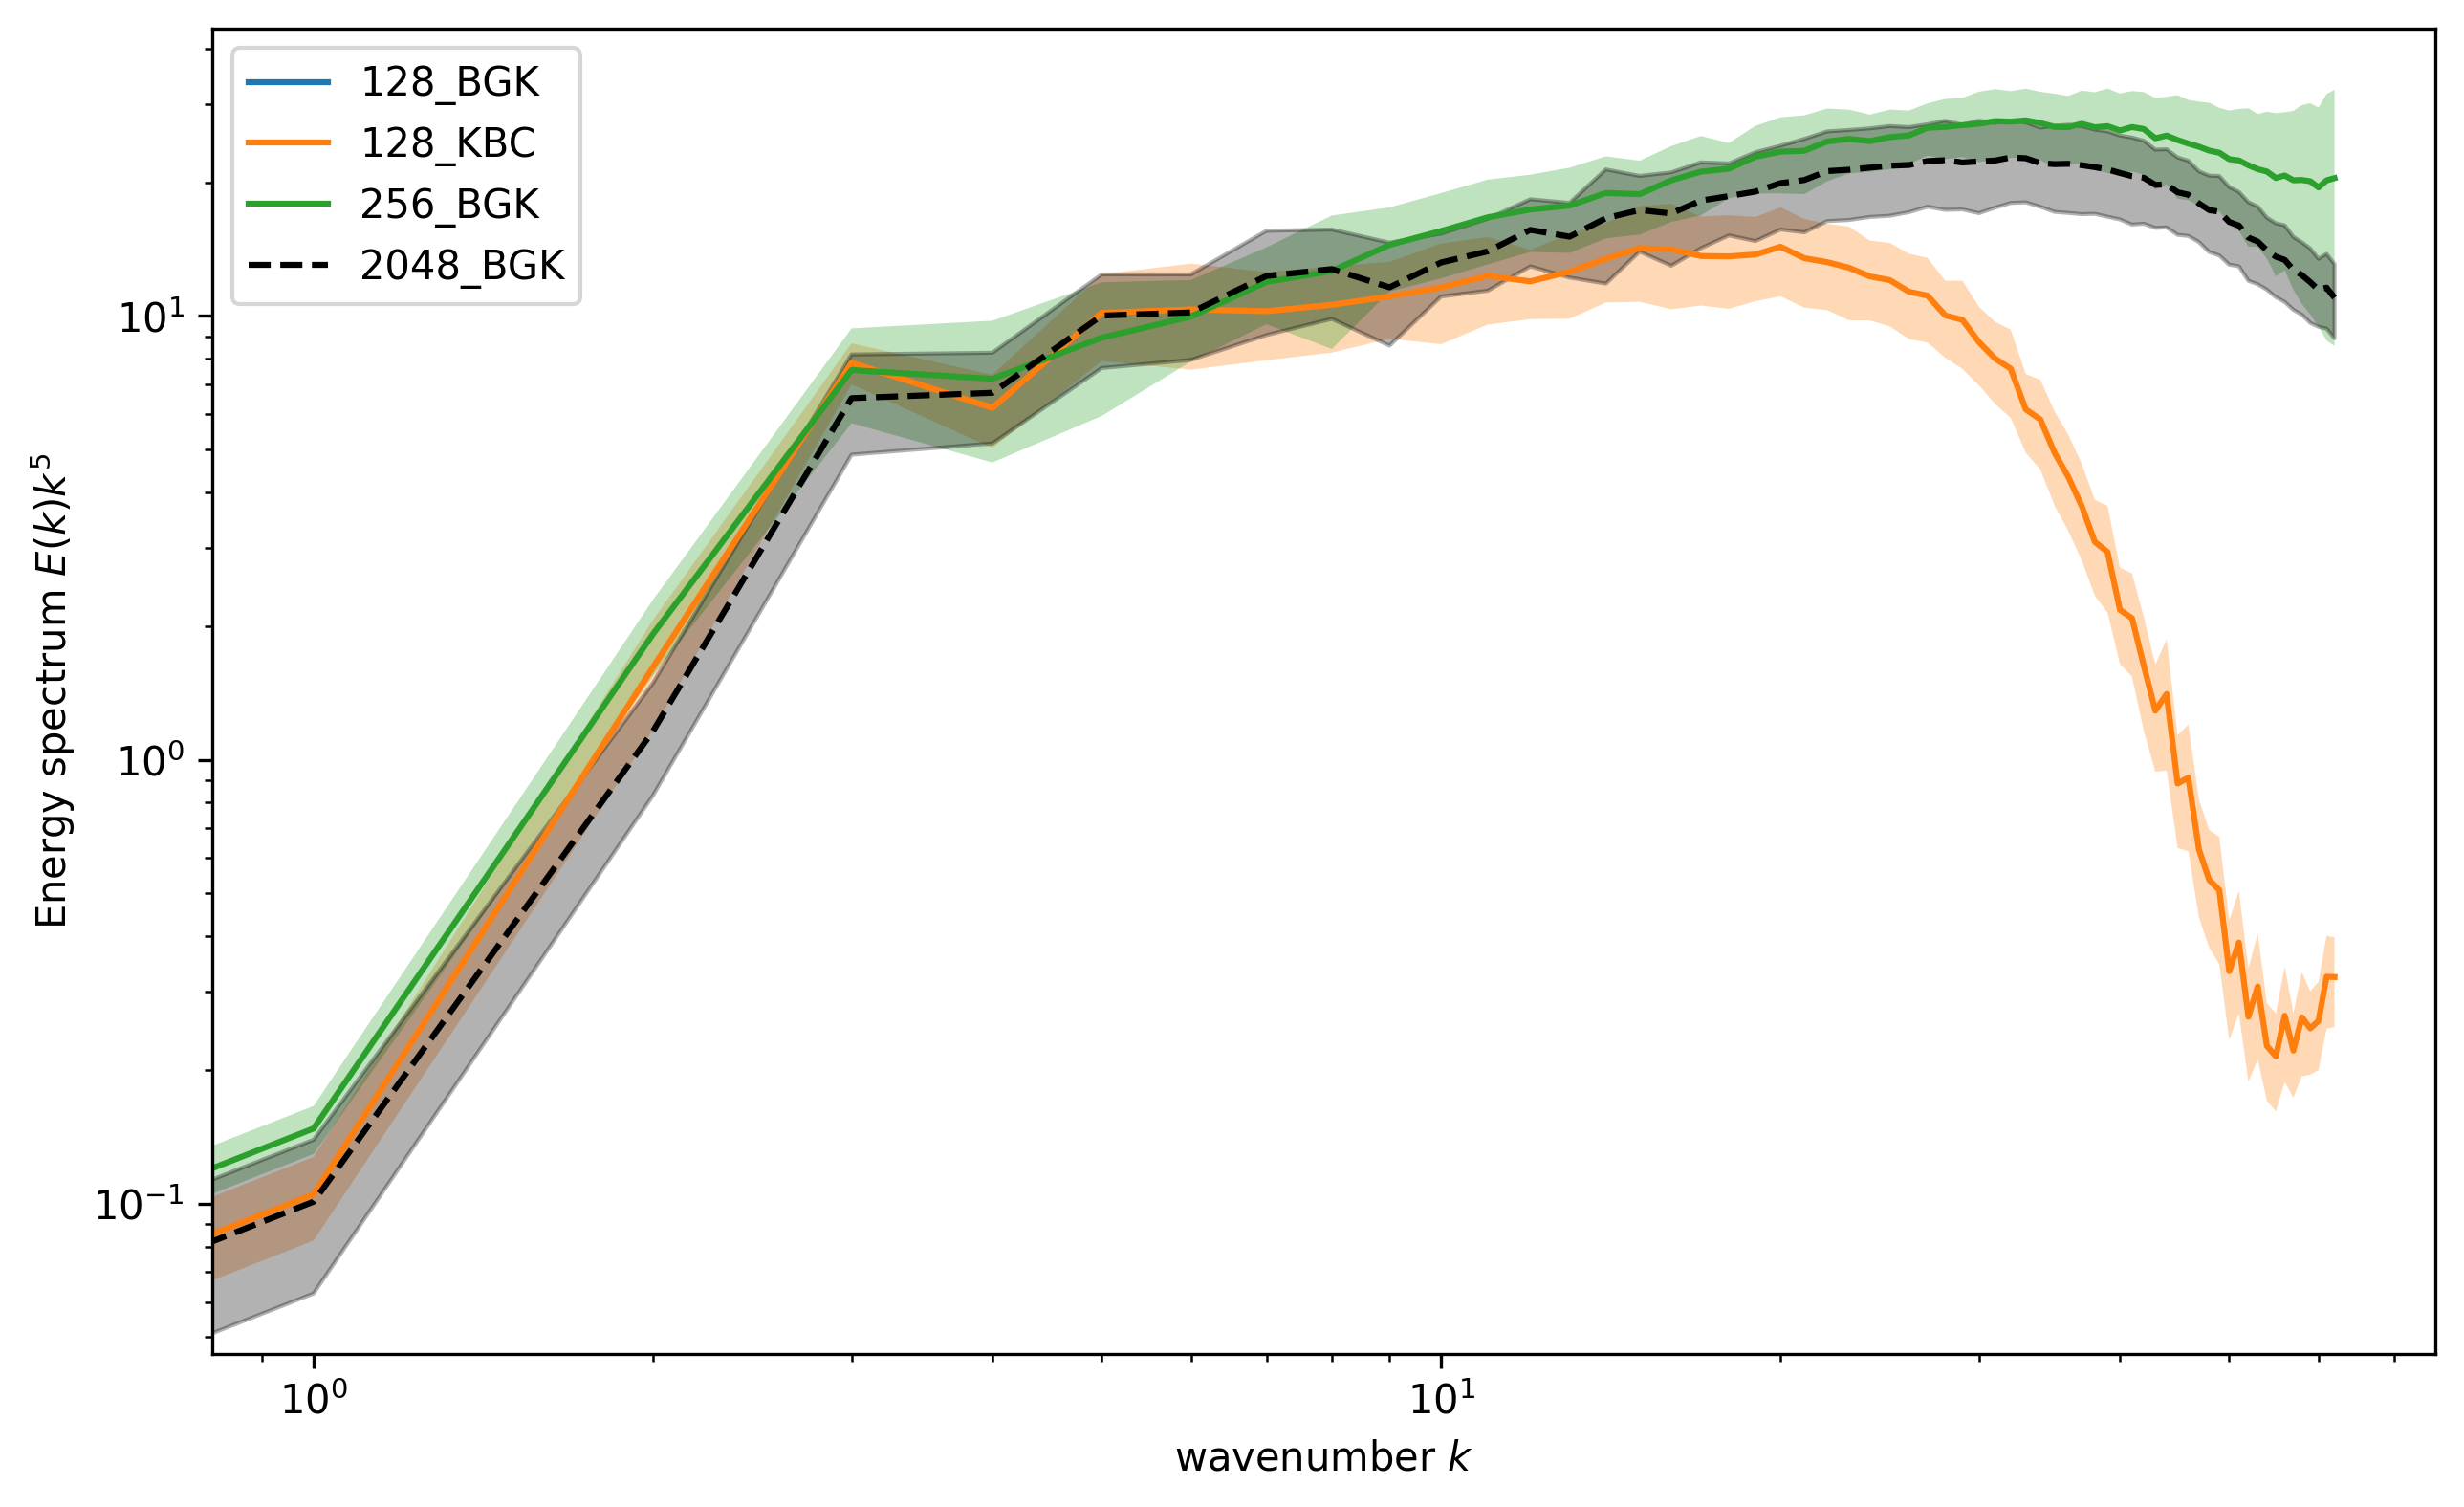

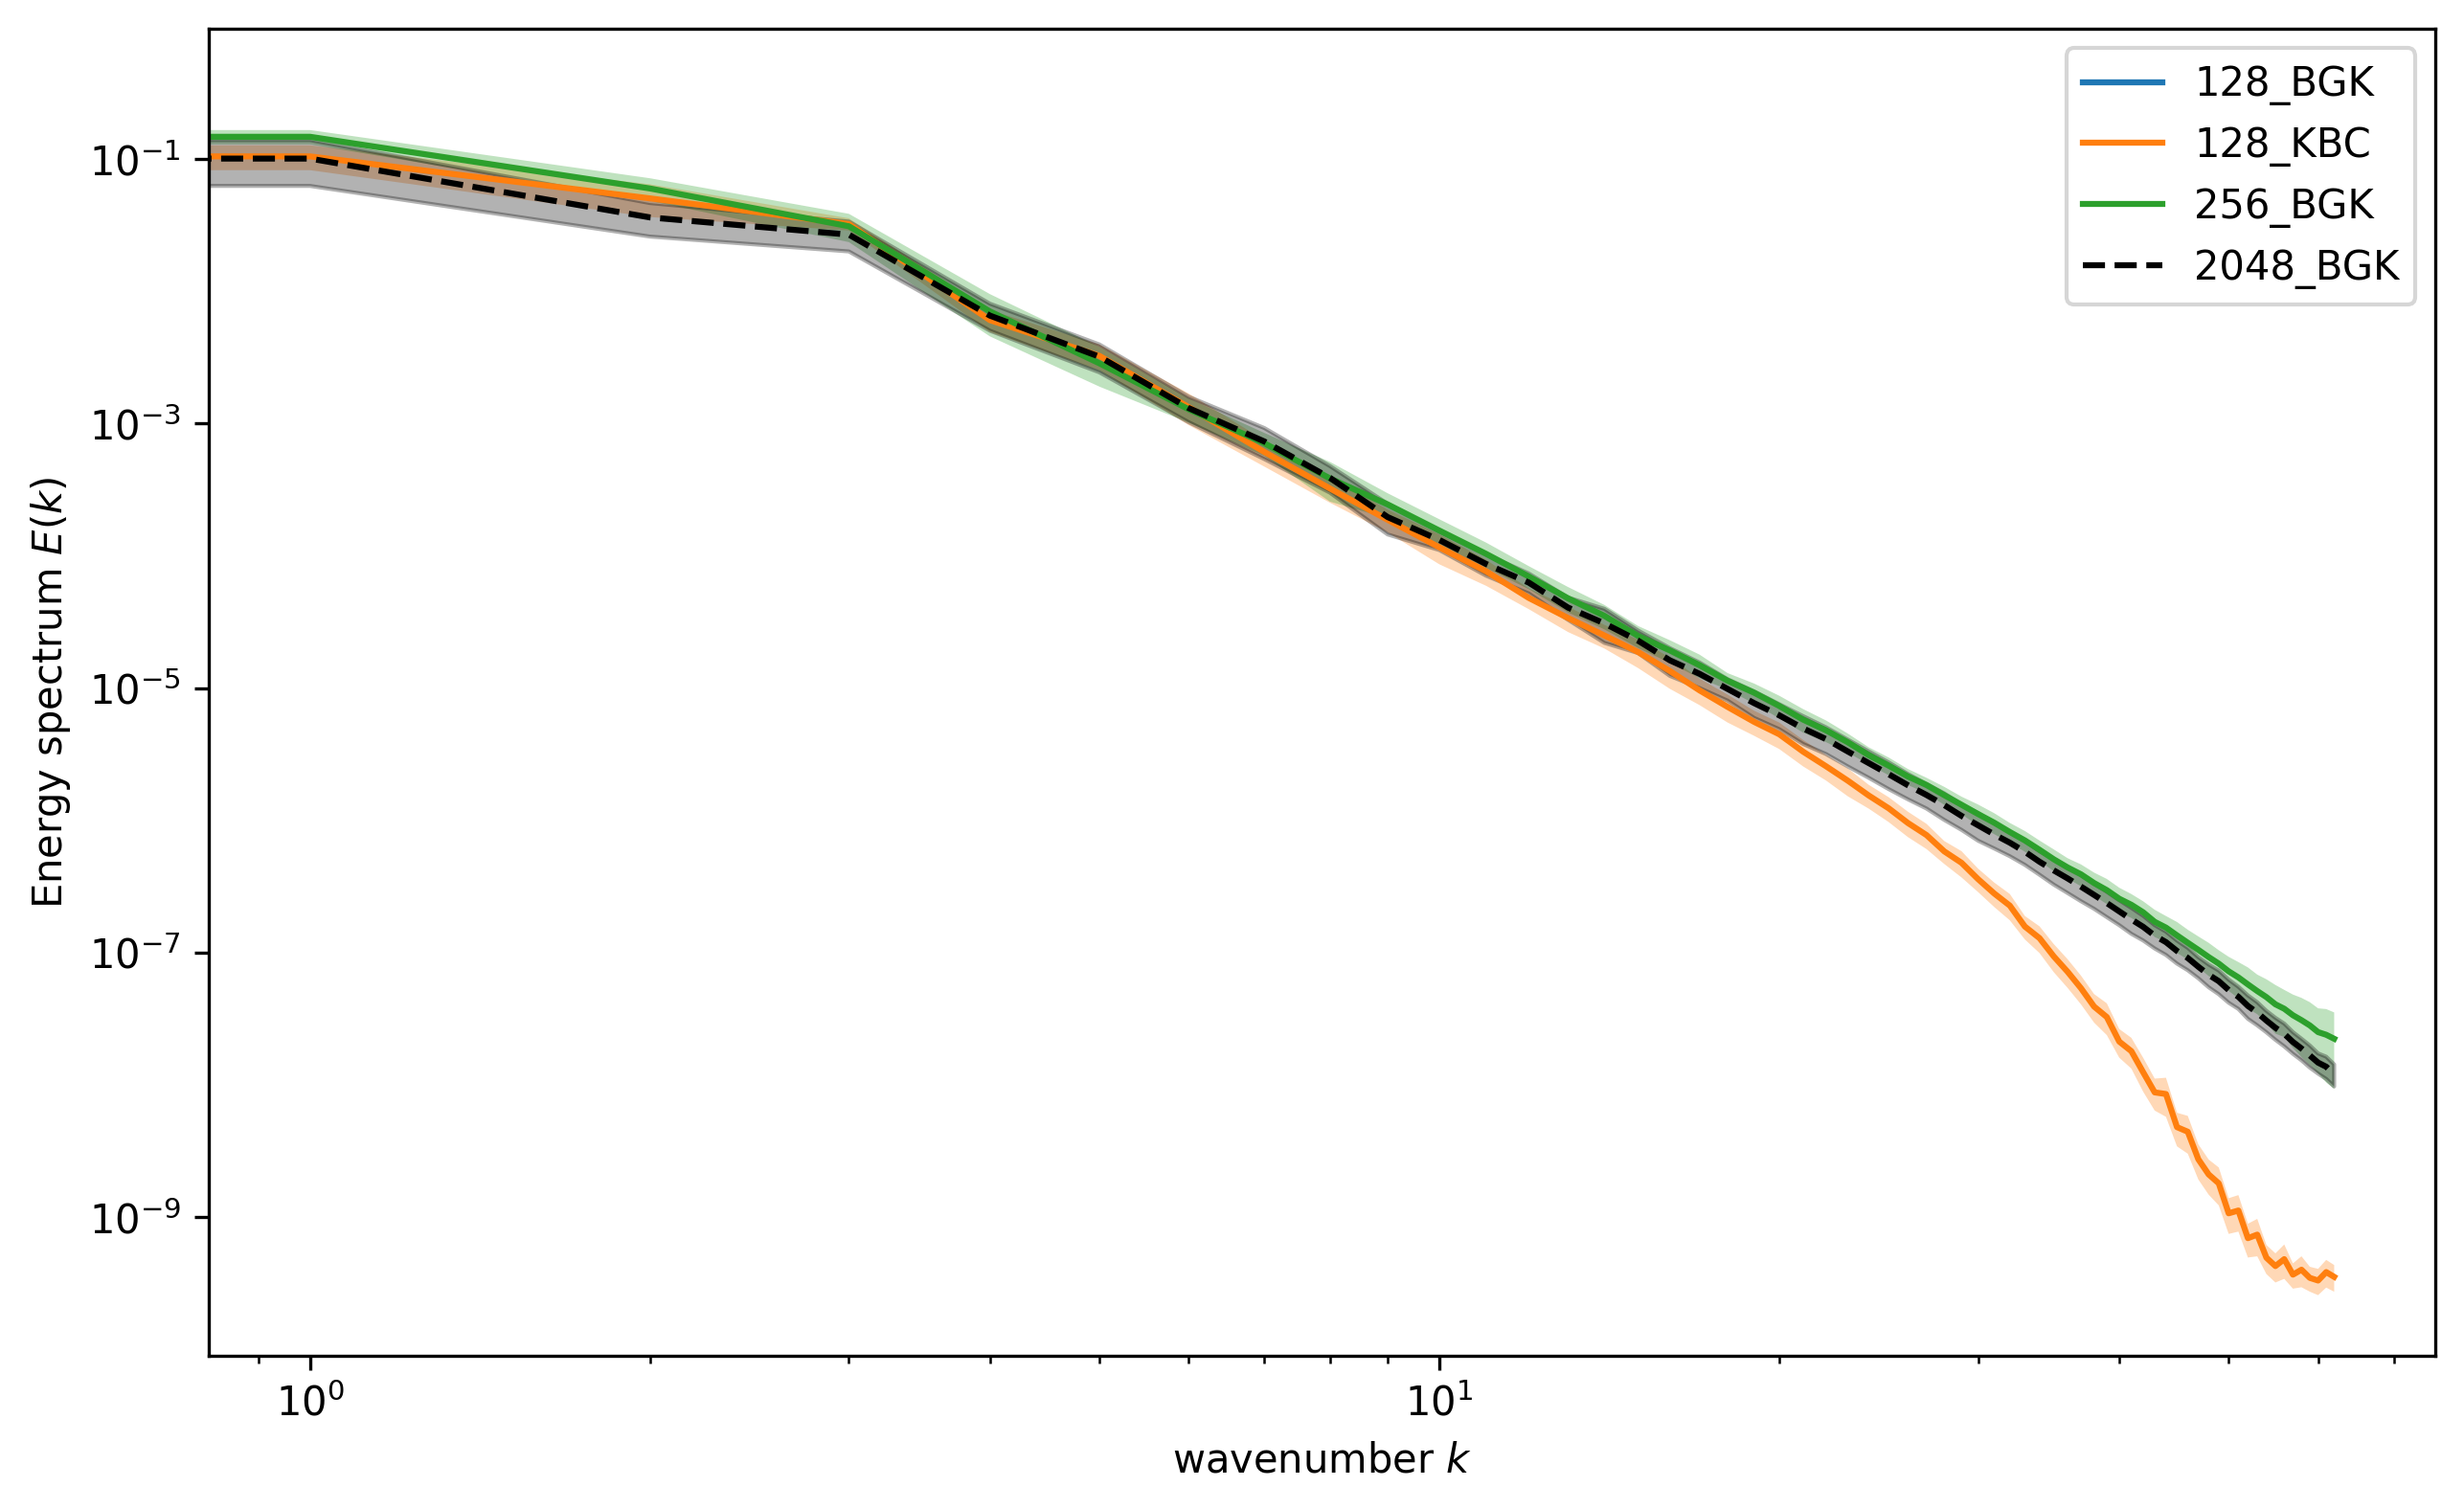

In [5]:
test_directory = "re10000_T227_S33_Kolmogorov_runs/"

# Get all folder names within `test_directory`
subfolders = [name for name in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, name))]
subfolders = np.sort(subfolders)

# Sort folders with custom key
subfolders = sorted(subfolders, key=custom_sort_key)
    
# Extract names={N}_{model} from each folder name
names = []
for folder in subfolders:
    match = re.search(r'N(\d+)_S\d+_U\d+_(\w+)', folder)
    if match:
        N = match.group(1)
        model = match.group(2)
        names.append(f"{N}_{model}")

names = sorted(names, key=custom_sort_key_names)
paths = [test_directory+subfolder+"/" for subfolder in subfolders]

#load all velocity files for all paths, and compute vorticity correlation
images = [get_names(path) for path in paths]
N = len(paths)
M = len(images[0])-1
corrs = np.zeros((M,N))
print("computing vorticity correlations:")
for i in tqdm(range(M)):
    #load all velocities 
    velocities = np.array([np.load(paths[j]+'/'+images[j][i]) for j in range(N)])
    vorticities = np.array([vorticity_2d(velocities[j,...], 2.0*np.pi/128) for j in range(N)])
    corrs[i,...] = np.array([np.corrcoef(vorticities[j,...].flatten(), vorticities[-1,...].flatten())[0, 1] 
                             for j in range(N)])
#plot correlations
plot_correlations(corrs, names, N, M)

#compute enerty spectrum statistics
L = int(128/2 - 1)
a = 1*M//2 #1*M//2
b = M-1
spec = np.zeros((N, L, (b-a)))
k = np.arange(L)
# loop over all files in files1 between a and b and add to spec
print("computing energy spectra:")
for i in tqdm(range(a, b)):
    velocities = np.array([np.load(paths[j]+'/'+images[j][i]) for j in range(N)])
    for j in range(N):
        _, spec[j,:,i-a] = energy_spectrum_2d(velocities[j,...])
spec_mean=spec.mean(axis=-1)
spec_std=spec.std(axis=-1)

# plot spectra
plot_spectra(spec_mean, spec_std, k, names, N)


In [6]:
#load old specrum:
spec_old_mean = np.load(
    "../xlb_flows/dns_spectrum/means_log_k5-10_dns.npy")
spec_old_std = np.load(
    "../xlb_flows/dns_spectrum/stds_log_k5-10_dns.npy")

In [4]:
#load old specrum:
spec_old_mean = np.load(
    "../xlb_flows/dns_spectrum/new_spec_mean.npy")
spec_old_std = np.load(
    "../xlb_flows/dns_spectrum/new_spec_std.npy")

In [7]:
scaled_spec = np.zeros((L-1, (b-a)))
for i in tqdm(range(a, b)):
    velocities = np.array(np.load(paths[-1]+'/'+images[-1][i]))
    for j in range(N):
        _, E = energy_spectrum_2d(velocities)
        scaled_spec[:,i-a] = np.log((E[1:]*k[1:]**5)/10)

100%|██████████| 312/312 [00:03<00:00, 103.78it/s]


In [10]:
old_spec_mean = np.load("../results2/dns_spectra/dns_mean.npy")

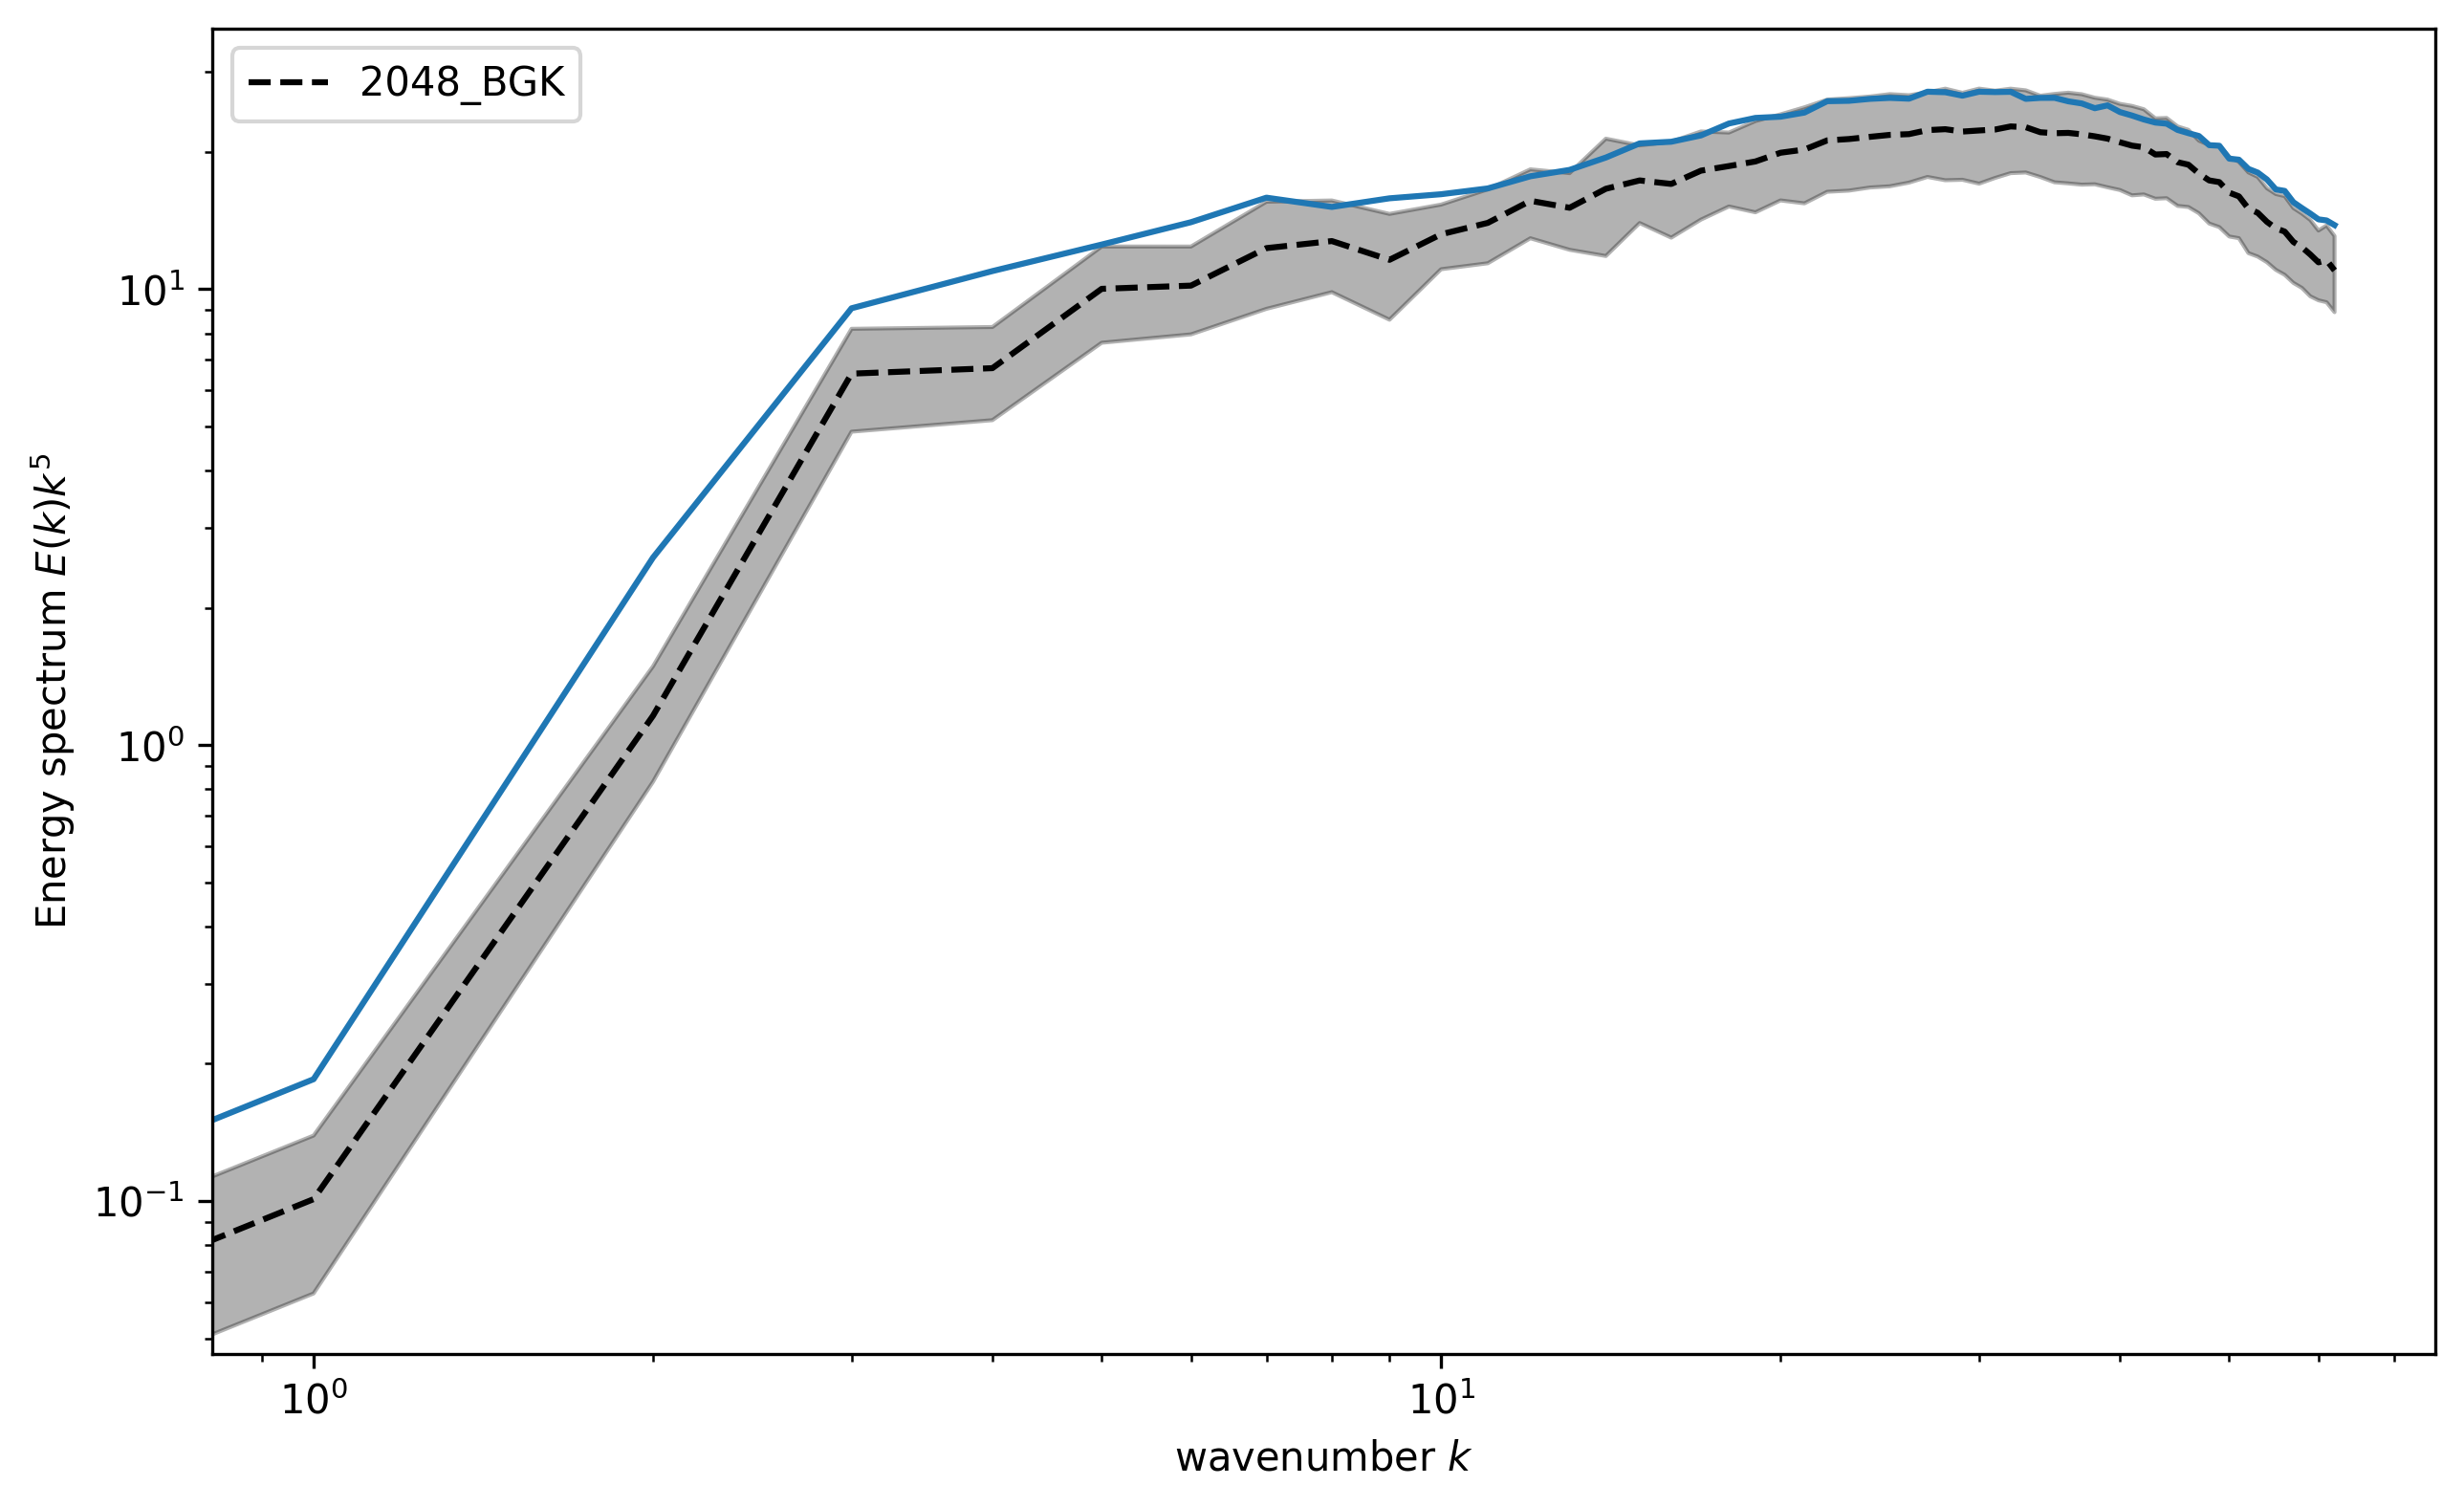

In [12]:
# plot the averaged spectrum
plt.figure(figsize=(10,6), dpi=300)
plt.set_cmap('cool')
plt.loglog(old_spec_mean*k**5)
plt.loglog(spec_mean[-1,...]*k**5,
           'k--',
           label=names[-1]
           )
plt.fill_between(k,
                 (k**5)*(spec_mean[-1,...]-spec_std[-1,...]),
                 (k**5)*(spec_mean[-1,...] + spec_std[-1,...]), 
                 alpha=0.3,
                 color='k'
                 )
plt.ylabel(r'Energy spectrum $E(k)k^5$')
plt.xlabel(r'wavenumber $k$')
plt.legend()
plt.show()  

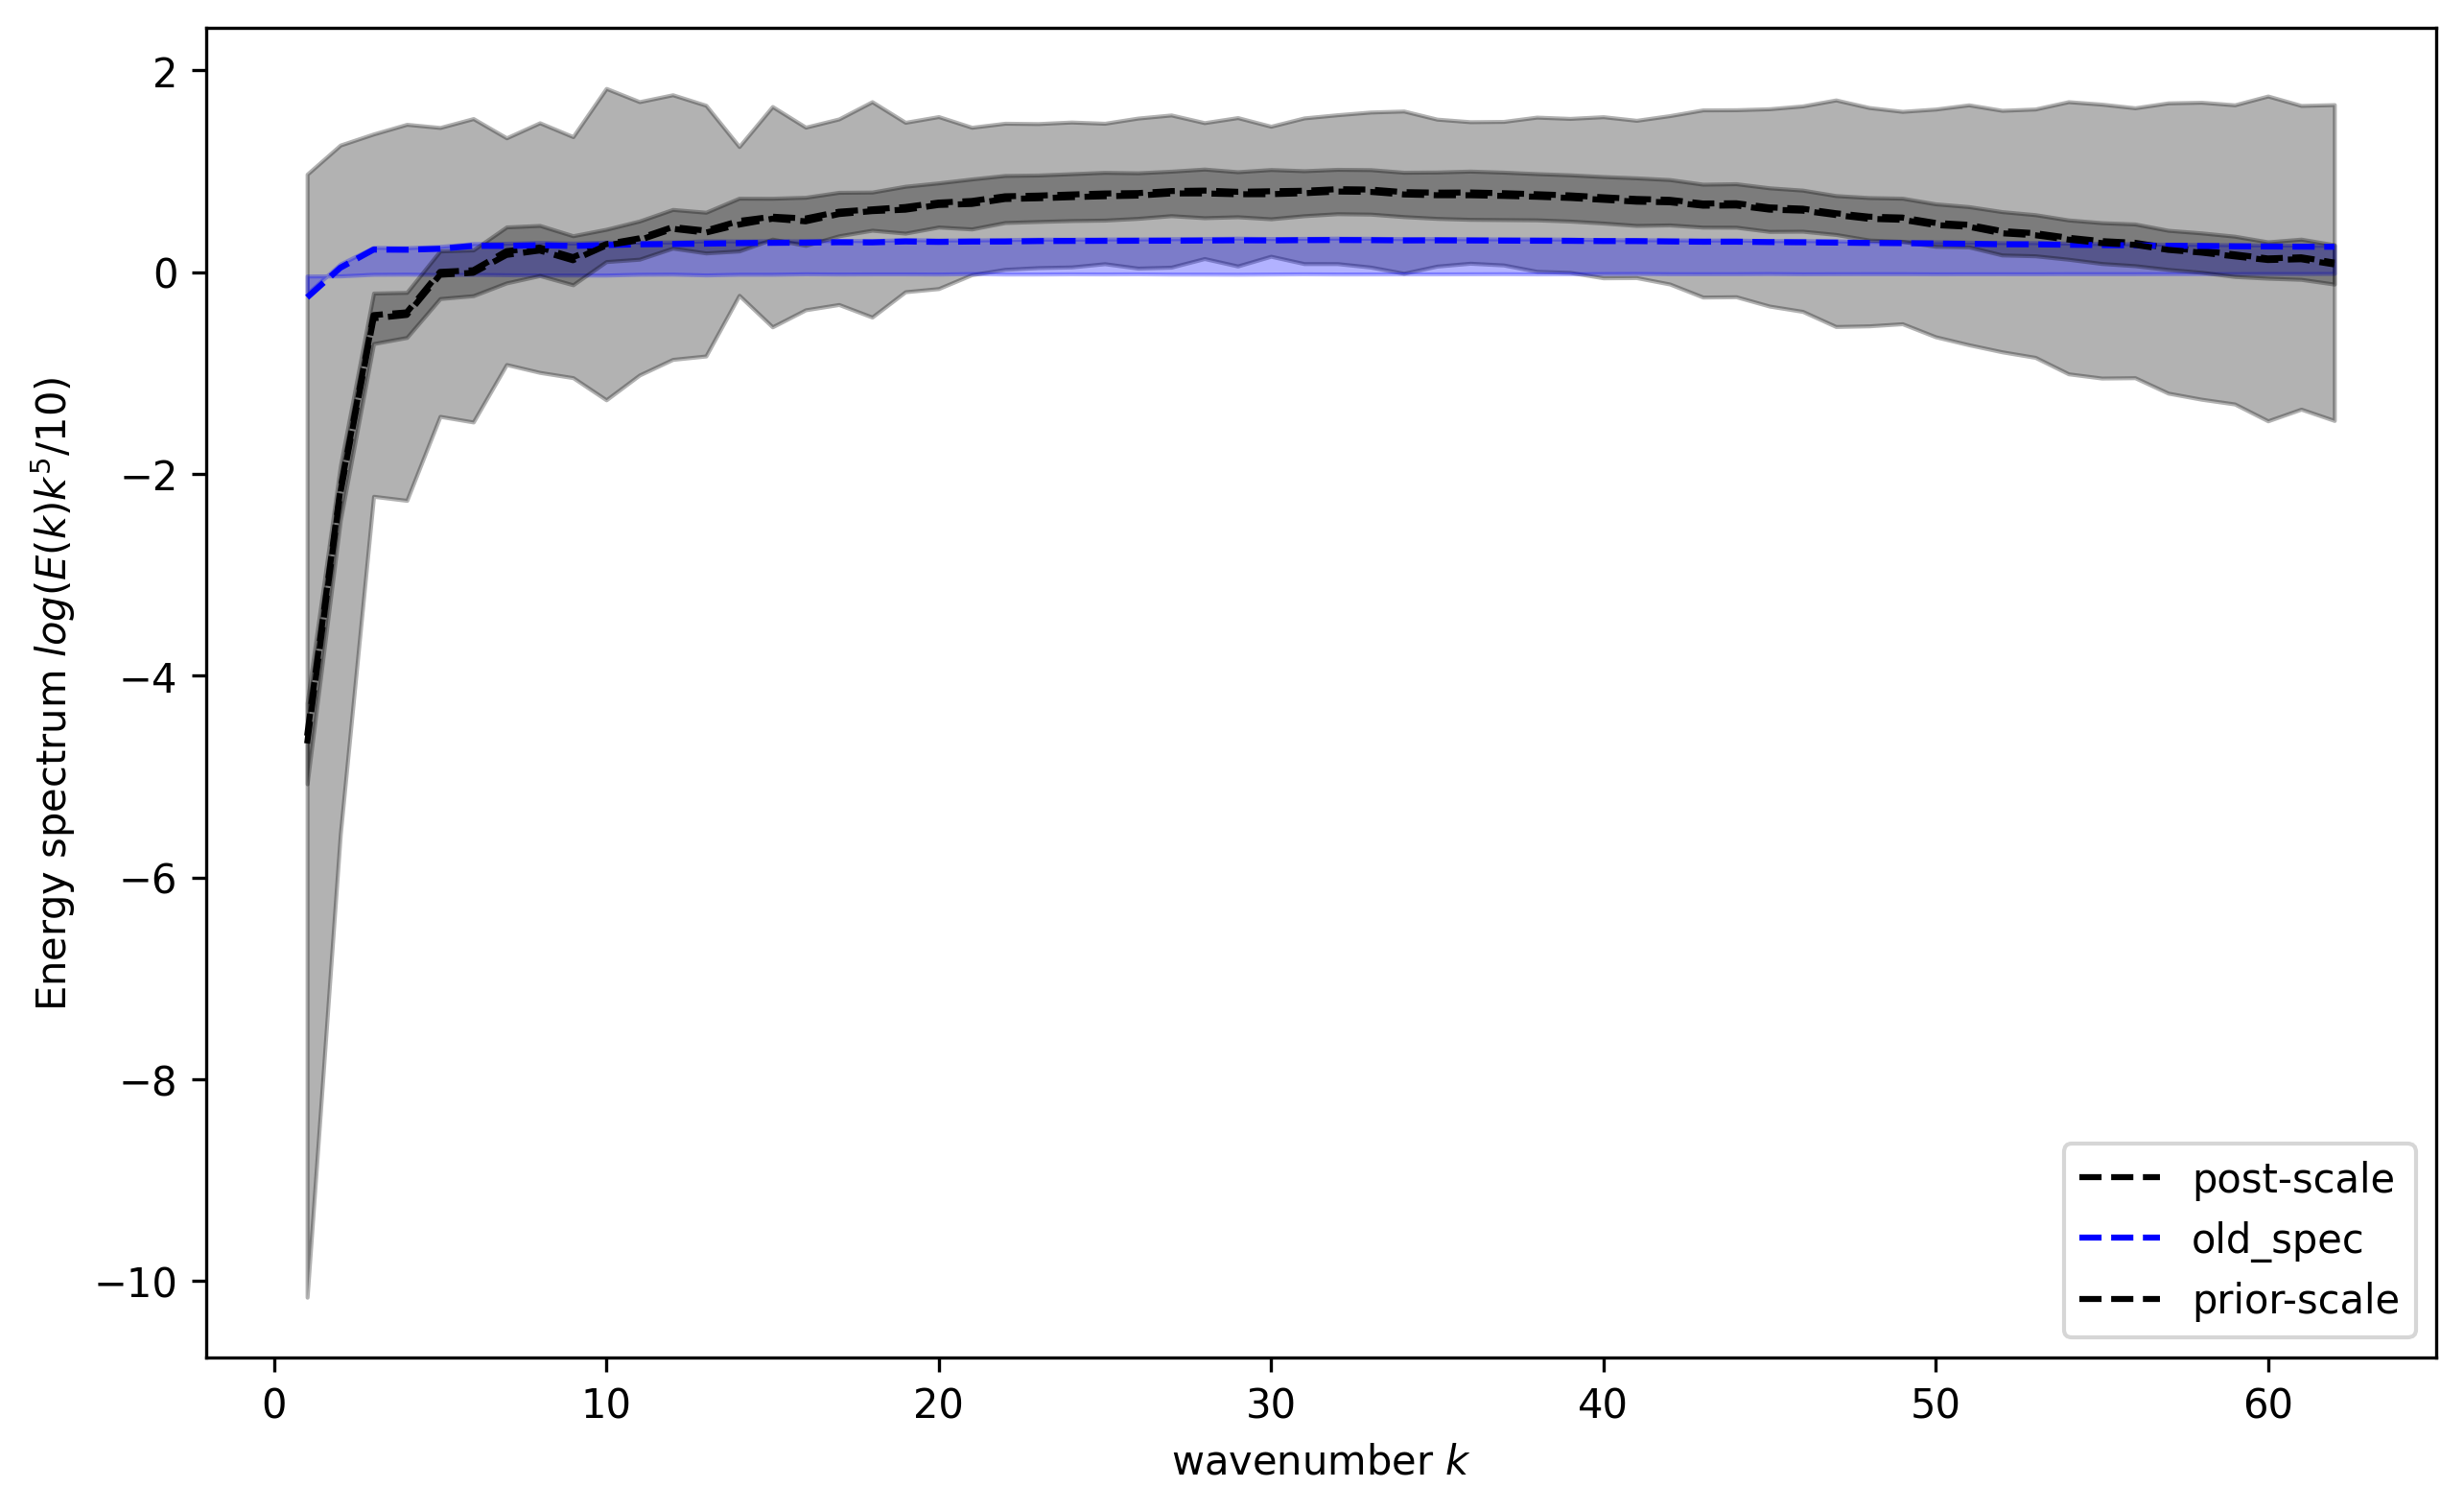

In [13]:
# plot the averaged spectrum
means = spec_mean[-1,...]
stds = spec_std[-1,...]

scaled_mean = scaled_spec.mean(axis=-1)
scaled_std = scaled_spec.std(axis=-1)

means = np.log((means[1:]*k[1:]**5)/10)
stds = np.log((stds[1:]*k[1:]**5)/10)

plt.figure(figsize=(10,6), dpi=300)
plt.set_cmap('cool')
plt.plot(k[1:],means,
           'k--',
           label="post-scale"
           )
plt.fill_between(k[1:],
                 (means-stds),
                 (means+stds), 
                 alpha=0.3,
                 color='k'
                 )
plt.plot(k[1:],spec_old_mean,
           'b--',
           label="old_spec"
           )
plt.fill_between(k[1:],
                 (-spec_old_std),
                 (spec_old_mean+spec_old_std), 
                 alpha=0.3,
                 color='b'
                 )
plt.plot(k[1:],scaled_mean,
           'k--',
           label="prior-scale"
           )
plt.fill_between(k[1:],
                 (scaled_mean-scaled_std),
                 (scaled_mean+scaled_std), 
                 alpha=0.3,
                 color='k'
                 )


plt.ylabel(r'Energy spectrum $log(E(k)k^5/10)$')
plt.xlabel(r'wavenumber $k$')
plt.legend()
plt.show()  

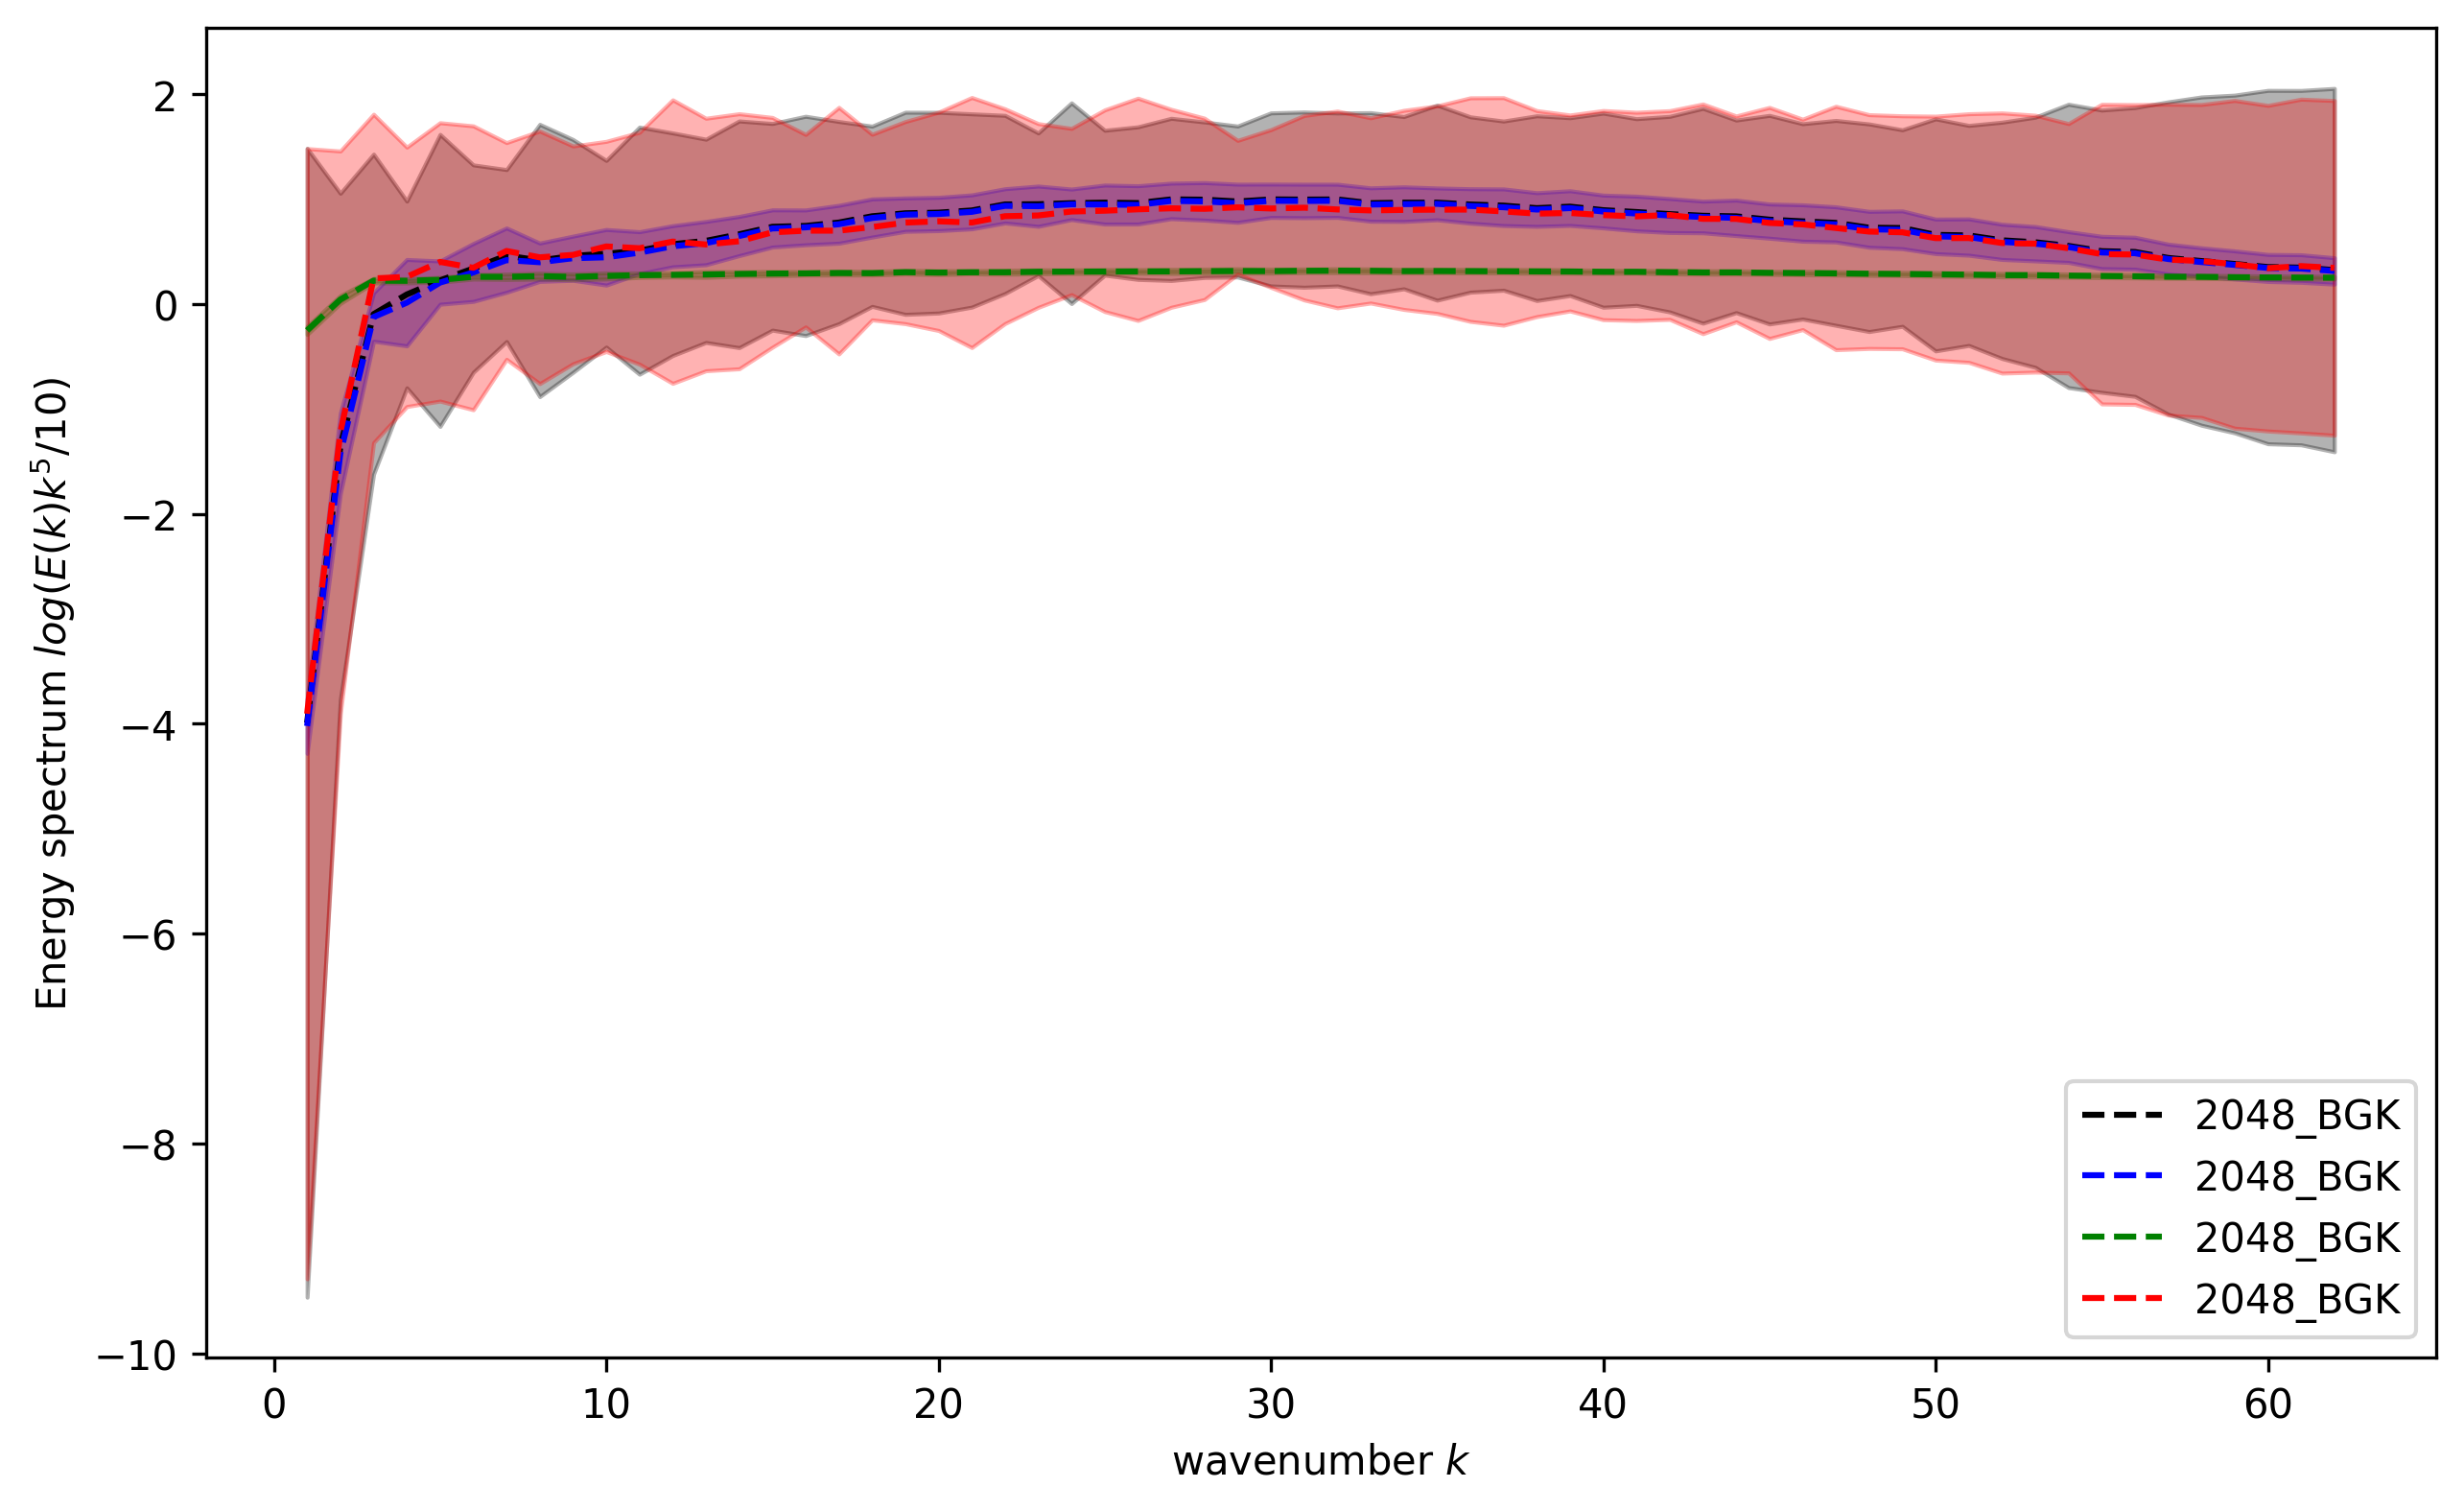

In [23]:
# plot the averaged spectrum
means = spec_mean[-1,...]
stds = spec_std[-1,...]

means_loc = spec_mean[2,...]
stds_loc = spec_std[2,...]

means = np.log((means[1:]*k[1:]**5)/10)
stds = np.log((stds[1:]*k[1:]**5)/10)

means_loc = np.log((means_loc[1:]*k[1:]**5)/10)
stds_loc = np.log((stds_loc[1:]*k[1:]**5)/10)

plt.figure(figsize=(10,6), dpi=300)
plt.set_cmap('cool')
plt.plot(k[1:],means,
           'k--',
           label=names[-1]
           )
plt.fill_between(k[1:],
                 (means-stds),
                 (means+stds), 
                 alpha=0.3,
                 color='k'
                 )
plt.plot(k[1:],scaled_spec.mean(axis=-1),
           'b--',
           label=names[-1]
           )
plt.fill_between(k[1:],
                 (scaled_spec.mean(axis=-1) - scaled_spec.std(axis=-1)),
                 (scaled_spec.mean(axis=-1) + scaled_spec.std(axis=-1)), 
                 alpha=0.3,
                 color='b'
                 )

plt.plot(k[1:], spec_old_mean,
           'g--',
           label=names[-1]
           )
plt.fill_between(k[1:],
                 (spec_old_mean-spec_old_std),
                 (spec_old_mean+spec_old_std), 
                 alpha=0.3,
                 color='g'
                 )

plt.plot(k[1:],means_loc,
           'r--',
           label=names[-1]
           )
plt.fill_between(k[1:],
                 (means_loc-stds_loc),
                 (means_loc+stds_loc), 
                 alpha=0.3,
                 color='r'
                 )

plt.ylabel(r'Energy spectrum $log(E(k)k^5/10)$')
plt.xlabel(r'wavenumber $k$')
plt.legend()
plt.show()  

In [13]:
mean_scaled = scaled_spec.mean(axis=-1)
std_scaled = scaled_spec.std(axis=-1)

In [14]:
def E_loss(means_cgs, means_dns, stds_dns):
        cov_inverse = np.diag(1/stds_dns)
        means_diff = means_cgs - means_dns
        return 1 + np.log(np.exp(-0.5 * means_diff.T @ cov_inverse @ means_diff))/64
    

In [20]:
E_loss(means_loc, means, np.abs(stds))

-3.0024864886974623

In [16]:
means_diff = means_loc - mean_scaled
print(means_diff.T @ np.diag(1/std_scaled) @ means_diff)
np.log(np.max([np.exp(-0.5 * means_diff.T @ np.diag(1/std_scaled) @ means_diff),1e-12]))/64

2879.753970912366


-0.43173470493638355

In [17]:
E_loss(means_loc, scaled_spec.mean(axis=-1), scaled_spec.std(axis=-1))

/tmp/ipykernel_3090464/789132248.py:4: RuntimeWarning: divide by zero encountered in log
  return 1 + np.log(np.exp(-0.5 * means_diff.T @ cov_inverse @ means_diff))/64


-inf

In [14]:
np.save("dns_mean.npy", spec_mean[-1,...])
np.save("dns_mean_scaled.npy", scaled_spec.mean(axis=-1))
np.save("dns_std_scaled_prior.npy", scaled_spec.mean(axis=-1))
np.save("dns_std_scaled_posterior.npy", np.log(((spec_std[-1,...])[1:]*k[1:]**5)/10))